# Scatter Search for the 0–1 Knapsack: Complete Implementation Tutorial

This notebook provides a comprehensive, step-by-step implementation of the Scatter Search (SS) metaheuristic for solving 0–1 knapsack problems. We build every component from scratch — **Diversification**, **Improvement**, **Reference Set**, **Subset Generation**, **Combination** — and integrate them into a complete optimization solver.

The tutorial emphasizes both theoretical understanding and practical implementation, with detailed visualizations to illustrate algorithm behavior throughout the search process.

## Learning Objectives

Upon completing this tutorial, you will master:
- **Diversification Generation Method**: Implement systematic binary vector generation using (h,q) toggling patterns and capacity-aware heuristics
- **Two-Phase Improvement Method**: Code feasibility repair and greedy optimization phases for high-quality solution construction
- **Reference Set Management**: Build and maintain RefSets balancing **solution quality** and **structural diversity**
- **Multi-Solution Combination**: Generate trial solutions from variable-sized subsets using weighted scoring methods
- **Complete Scatter Search**: Execute the full algorithm with update/rebuild cycles and comprehensive performance visualization

## Environment Setup

This section configures the computational environment for the Scatter Search implementation with focus on **reproducibility** and **robustness**.

### Dependencies and Their Roles

**Core Algorithmic Libraries:**
- `random`: Python's built-in random number generator for solution initialization and stochastic operations
- `numpy`: Efficient numerical computations for arrays, mathematical operations, and advanced random sampling
- `dataclasses`: Clean data structure definitions with automatic special methods (e.g., `__init__`, `__repr__`)
- `typing`: Type annotations for better code clarity, IDE support, and static analysis

**Data Management and Visualization:**
- `pandas`: Structured data organization for algorithm performance tracking and result analysis
- `matplotlib.pyplot`: Comprehensive plotting capabilities for algorithm visualization and convergence analysis
- `matplotlib.lines`: Custom line objects for plot legends and formatting

**System and Utility:**
- `os`: File system operations for benchmark instance loading and path management
- `itertools`: Efficient combinatorial operations for subset generation and solution combination
- `time`: Execution timing for performance measurement and logging

### Reproducibility Strategy

This notebook implements a **multi-level seeding strategy** to ensure identical results across different environments and multiple runs:

1. **Python's random module**: Controls built-in random functions
2. **NumPy's random state**: Controls numpy random operations  
3. **Consistent seed values**: Fixed seeds chosen for this tutorial


In [1]:
# Core algorithmic libraries
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Any
import itertools
import math

# Data management and visualization
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# System utilities
import os
import sys
import time

# Version verification for reproducibility
print("Environment Configuration:")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

# Multi-level seeding for complete reproducibility
RANDOM_SEED = 133
NUMPY_SEED = 12

random.seed(RANDOM_SEED)
np.random.seed(NUMPY_SEED)

# Verify seed effectiveness
print(f"\nRandomization Test (should be identical across runs):")
print(f"Python random sample: {random.sample(range(100), 5)}")
print(f"NumPy random sample: {np.random.randint(0, 100, 5).tolist()}")

# Matplotlib configuration for consistent, publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("\n✓ Environment setup completed successfully")

Environment Configuration:
Python version: 3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]
NumPy version: 1.26.4
Pandas version: 2.2.1
Matplotlib version: 3.9.2

Randomization Test (should be identical across runs):
Python random sample: [63, 45, 61, 41, 98]
NumPy random sample: [75, 27, 6, 2, 3]

✓ Environment setup completed successfully


## Instance Selection and Configuration

This section provides flexible instance management for the Scatter Search algorithm, supporting both educational examples and benchmark datasets for comprehensive algorithm evaluation.

### Configuration Options

**Instance Source Selection:**
- `USE_FILE_INSTANCE = False`: Use predefined educational instance (recommended for learning)
- `USE_FILE_INSTANCE = True`: Load from benchmark files (for performance evaluation)

**Benchmark Dataset Structure:**
The notebook supports the Pisinger benchmark dataset, a widely-used collection of knapsack instances with known optimal solutions:

- **`low-dimensional`**: Smaller instances (n ≤ 50 items) ideal for:
  - Algorithm debugging and validation
  - Educational demonstrations 
  - Quick testing of modifications
  
- **`large_scale`**: Larger instances (n ≥ 100 items) suitable for:
  - Performance benchmarking
  - Scalability analysis
  - Research experiments

### File Format Specification

Standard knapsack instance format:
```
n wmax
v1 w1
v2 w2
...
vn wn
```

**Where:**
- `n`: Number of items in the instance
- `wmax`: Maximum knapsack capacity
- `vi`: Value/profit of item i
- `wi`: Weight of item i

### Educational Instance Details

The default hardcoded instance is carefully designed for tutorial purposes:
- **Size**: 20 items (manageable for detailed analysis)
- **Capacity**: 150 units (allows for interesting solution diversity)
- **Profit/weight ratios**: Varied to demonstrate different selection strategies
- **Optimal solution**: Multiple high-quality solutions exist for educational exploration

This instance balances complexity with comprehensibility, making it ideal for understanding algorithm behavior step-by-step.

In [2]:
# Instance Configuration Parameters
USE_FILE_INSTANCE = False  # Set to True to use benchmark instances
INSTANCE_CATEGORY = "large_scale"  # Options: 'low-dimensional' or 'large_scale'
INSTANCE_FILE = "knapPI_1_500_1000_1"  # Specific instance filename
BASE_PATH = "instances_01_KP"  # Base directory for benchmark instances

def load_instance_from_file(instance_path: str) -> Tuple[List[int], List[int], int, int]:
    """
    Load a knapsack instance from file with comprehensive error handling.
    
    Args:
        instance_path: Path to the instance file
    
    Returns:
        Tuple of (profits, weights, capacity, n) where:
        - profits: List of item profits/values
        - weights: List of item weights  
        - capacity: Maximum knapsack capacity
        - n: Number of items
        
    Raises:
        FileNotFoundError: If instance file doesn't exist
        ValueError: If file format is invalid
    """
    if not os.path.exists(instance_path):
        raise FileNotFoundError(f"Instance file not found: {instance_path}")
    
    try:
        with open(instance_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
        
        if len(lines) < 1:
            raise ValueError("Empty or invalid instance file")
        
        # Parse header: n wmax
        header_parts = lines[0].split()
        if len(header_parts) != 2:
            raise ValueError("Invalid header format. Expected: 'n wmax'")
        
        n, capacity = map(int, header_parts)
        
        if n <= 0 or capacity <= 0:
            raise ValueError(f"Invalid instance parameters: n={n}, capacity={capacity}")
        
        if len(lines) < n + 1:
            raise ValueError(f"Insufficient data lines. Expected {n+1}, found {len(lines)}")
        
        profits, weights = [], []
        
        # Parse item data
        for i in range(1, n + 1):
            item_parts = lines[i].split()
            if len(item_parts) != 2:
                raise ValueError(f"Invalid item format at line {i+1}")
            
            v, w = map(int, item_parts)
            if v < 0 or w <= 0:
                raise ValueError(f"Invalid item values at line {i+1}: value={v}, weight={w}")
            
            profits.append(v)
            weights.append(w)
        
        return profits, weights, capacity, n
        
    except (ValueError, IndexError) as e:
        raise ValueError(f"Error parsing instance file: {e}")

def list_available_instances(base_path: str = BASE_PATH) -> Dict[str, List[str]]:
    """
    Discover and organize available benchmark instances.
    
    Args:
        base_path: Base directory containing instance categories
        
    Returns:
        Dictionary mapping category names to sorted lists of instance filenames
    """
    instances = {}
    
    if not os.path.exists(base_path):
        print(f"Warning: Benchmark directory '{base_path}' not found")
        return instances
    
    try:
        for category in os.listdir(base_path):
            category_path = os.path.join(base_path, category)
            if os.path.isdir(category_path) and not category.endswith('-optimum'):
                category_files = []
                for file in os.listdir(category_path):
                    file_path = os.path.join(category_path, file)
                    if os.path.isfile(file_path):
                        category_files.append(file)
                
                if category_files:  # Only include non-empty categories
                    instances[category] = sorted(category_files)
    
    except Exception as e:
        print(f"Warning: Error scanning benchmark directory: {e}")
    
    return instances

def validate_instance(profits: List[int], weights: List[int], capacity: int) -> bool:
    """
    Validate instance data for consistency and reasonableness.
    
    Args:
        profits: List of item profits
        weights: List of item weights
        capacity: Knapsack capacity
        
    Returns:
        True if instance is valid, False otherwise
    """
    if len(profits) != len(weights):
        print(f"Error: Mismatched array lengths - profits: {len(profits)}, weights: {len(weights)}")
        return False
    
    if len(profits) == 0:
        print("Error: Empty instance")
        return False
    
    if capacity <= 0:
        print(f"Error: Invalid capacity: {capacity}")
        return False
    
    if any(w <= 0 for w in weights):
        print("Error: Non-positive weights found")
        return False
    
    if any(p < 0 for p in profits):
        print("Error: Negative profits found")
        return False
    
    # Check if at least one item can fit
    min_weight = min(weights)
    if min_weight > capacity:
        print(f"Warning: No items can fit in knapsack (min weight: {min_weight}, capacity: {capacity})")
    
    return True

# Discover available benchmark instances
print("=== Instance Discovery ===")
available_instances = list_available_instances()
if available_instances:
    print("Available benchmark categories:")
    for category, files in available_instances.items():
        print(f"  📁 {category}: {len(files)} instances")
        if files:
            print(f"     Examples: {', '.join(files[:3])}{'...' if len(files) > 3 else ''}")
else:
    print("No benchmark instances found. Using educational instance only.")

# Load selected instance
print(f"\n=== Instance Loading ===")
if USE_FILE_INSTANCE:
    try:
        instance_path = os.path.join(BASE_PATH, INSTANCE_CATEGORY, INSTANCE_FILE)
        print(f"Loading: {instance_path}")
        profits, weights, capacity, n = load_instance_from_file(instance_path)
        print(f"✓ Successfully loaded benchmark instance")
        instance_source = f"{INSTANCE_CATEGORY}/{INSTANCE_FILE}"
    except (FileNotFoundError, ValueError) as e:
        print(f"❌ Error loading benchmark instance: {e}")
        print("⚠️  Falling back to educational instance")
        USE_FILE_INSTANCE = False

if not USE_FILE_INSTANCE:
    # Educational instance - designed for tutorial clarity
    print("Loading educational instance")
    profits = [24, 18, 15, 40, 22, 33, 17, 28, 19, 31, 25, 14, 37, 21, 16, 29, 23, 35, 20, 27]
    weights = [12, 25, 18, 32, 20, 27, 15, 22, 19, 24, 17, 13, 30, 21, 16, 26, 14, 28, 23, 20]
    capacity = 150
    n = len(profits)
    instance_source = "educational"
    print(f"✓ Educational instance loaded")

# Validate loaded instance
print(f"\n=== Instance Validation ===")
if validate_instance(profits, weights, capacity):
    print(f"✓ Instance validation successful")
    print(f"📊 Instance Details:")
    print(f"   Source: {instance_source}")
    print(f"   Items: {n}")
    print(f"   Capacity: {capacity}")
    print(f"   Total value: {sum(profits)}")
    print(f"   Total weight: {sum(weights)}")
    print(f"   Weight utilization if all selected: {sum(weights)/capacity:.1%}")
    print(f"   Average profit/weight ratio: {sum(profits)/sum(weights):.3f}")
else:
    raise ValueError("Instance validation failed")

=== Instance Discovery ===
Available benchmark categories:
  📁 low-dimensional: 10 instances
     Examples: f10_l-d_kp_20_879, f1_l-d_kp_10_269, f2_l-d_kp_20_878...
  📁 large_scale: 21 instances
     Examples: knapPI_1_10000_1000_1, knapPI_1_1000_1000_1, knapPI_1_100_1000_1...

=== Instance Loading ===
Loading educational instance
✓ Educational instance loaded

=== Instance Validation ===
✓ Instance validation successful
📊 Instance Details:
   Source: educational
   Items: 20
   Capacity: 150
   Total value: 494
   Total weight: 422
   Weight utilization if all selected: 281.3%
   Average profit/weight ratio: 1.171


# The 0-1 Knapsack Problem

The 0-1 Knapsack Problem is a fundamental combinatorial optimization problem with applications in resource allocation, portfolio selection, and many other domains. The challenge is to select a subset of items that maximizes total value while respecting a weight capacity constraint.

## Mathematical Formulation

**Objective:** Maximize total profit of selected items
$$\text{Maximize } \sum_{i=1}^{n} v_i \cdot x_i$$

**Constraint:** Respect knapsack capacity
$$\text{Subject to } \sum_{i=1}^{n} w_i \cdot x_i \leq W$$

**Variable bounds:** Binary selection
$$x_i \in \{0, 1\} \quad \forall i \in \{1, 2, \ldots, n\}$$

**Where:**
- $v_i$ is the profit/value of item $i$
- $w_i$ is the weight of item $i$
- $x_i$ is a binary decision variable (1 if item $i$ is selected, 0 otherwise)
- $W$ is the maximum weight capacity of the knapsack
- $n$ is the total number of available items

## Problem Characteristics

The 0-1 knapsack problem is:
- **NP-hard**: No polynomial-time algorithm is known for the general case
- **Binary**: Each item can be either included or excluded (no fractional selection)
- **Single constraint**: Only one capacity constraint (extendable to multiple constraints)
- **Maximization**: Seeks to maximize total value (vs. minimization problems)

## Instance Complexity Factors

The difficulty of a knapsack instance depends on several factors:
- **Size (n)**: Number of items available for selection
- **Capacity tightness**: Ratio of capacity to total weight of all items
- **Profit correlation**: Relationship between item profits and weights
- **Optimal solution density**: Number of items in the optimal solution

Our educational instance is designed to demonstrate various algorithmic behaviors while remaining comprehensible for step-by-step analysis.

In [3]:
@dataclass(frozen=True)
class KnapsackProblem:
    """
    Immutable data structure representing a 0-1 Knapsack Problem instance.
    
    This class encapsulates all problem-specific data and provides convenient
    methods for accessing derived properties commonly used in optimization algorithms.
    
    Attributes:
        profits: List of item profits/values (must be non-negative)
        weights: List of item weights (must be positive)
        capacity: Maximum knapsack weight capacity (must be positive)
    
    Properties:
        n: Number of items in the problem instance
        density: Average profit per unit weight across all items
        efficiency_ratios: Profit-to-weight ratio for each item
        total_profit: Sum of all item profits
        total_weight: Sum of all item weights
    
    Example:
        >>> problem = KnapsackProblem([10, 40, 30, 50], [5, 4, 6, 3], 10)
        >>> problem.n
        4
        >>> problem.density
        3.25
    """
    profits: List[int]
    weights: List[int] 
    capacity: int
    
    def __post_init__(self):
        """Validate problem instance after initialization."""
        if len(self.profits) != len(self.weights):
            raise ValueError(f"Mismatched array lengths: profits={len(self.profits)}, weights={len(self.weights)}")
        
        if len(self.profits) == 0:
            raise ValueError("Empty problem instance")
        
        if self.capacity <= 0:
            raise ValueError(f"Invalid capacity: {self.capacity}")
        
        if any(w <= 0 for w in self.weights):
            raise ValueError("All weights must be positive")
        
        if any(p < 0 for p in self.profits):
            raise ValueError("All profits must be non-negative")

    @property
    def n(self) -> int:
        """Number of items in the problem instance."""
        return len(self.profits)
    
    @property
    def efficiency_ratios(self) -> np.ndarray:
        """Profit-to-weight ratio for each item, useful for greedy heuristics."""
        return np.array(self.profits) / np.array(self.weights)
    
    @property
    def total_profit(self) -> int:
        """Total profit if all items were selected (upper bound)."""
        return sum(self.profits)
    
    @property
    def total_weight(self) -> int:
        """Total weight if all items were selected."""
        return sum(self.weights)
    
    @property
    def density(self) -> float:
        """Average profit per unit weight across all items."""
        return self.total_profit / self.total_weight
    
    @property
    def weight_utilization_if_all_selected(self) -> float:
        """Fraction of capacity used if all items were selected."""
        return self.total_weight / self.capacity
    
    @property
    def lightest_item_weight(self) -> int:
        """Weight of the lightest item (useful for feasibility checks)."""
        return min(self.weights)
    
    @property
    def most_valuable_item_profit(self) -> int:
        """Profit of the most valuable item."""
        return max(self.profits)
    
    def get_sorted_indices_by_efficiency(self, ascending: bool = False) -> List[int]:
        """
        Get item indices sorted by profit/weight efficiency ratio.
        
        Args:
            ascending: If True, return worst efficiency first; if False, best first
            
        Returns:
            List of item indices sorted by efficiency ratio
        """
        indices = list(range(self.n))
        ratios = self.efficiency_ratios
        indices.sort(key=lambda i: ratios[i], reverse=not ascending)
        return indices
    
    def __str__(self) -> str:
        """Human-readable string representation."""
        return (f"KnapsackProblem(n={self.n}, capacity={self.capacity}, "
                f"total_value={self.total_profit}, total_weight={self.total_weight}, "
                f"density={self.density:.3f})")

# Create and validate problem instance
try:
    problem = KnapsackProblem(profits=profits, weights=weights, capacity=capacity)
    print(f"✓ Problem instance created successfully")
    print(f"📊 {problem}")
    
    # Additional instance analysis
    print(f"\n=== Instance Analysis ===")
    print(f"Efficiency range: {problem.efficiency_ratios.min():.3f} - {problem.efficiency_ratios.max():.3f}")
    print(f"Weight utilization if all selected: {problem.weight_utilization_if_all_selected:.1%}")
    print(f"Lightest item weight: {problem.lightest_item_weight}")
    print(f"Most valuable item profit: {problem.most_valuable_item_profit}")
    
except ValueError as e:
    print(f"❌ Error creating problem instance: {e}")
    raise

# Create comprehensive item analysis table
print(f"\n=== Item Details ===")
df_items = pd.DataFrame({
    'Item': np.arange(1, problem.n + 1),
    'Profit': problem.profits,
    'Weight': problem.weights,
    'Efficiency': problem.efficiency_ratios.round(3),
    'Profit %': (np.array(problem.profits) / problem.total_profit * 100).round(1),
    'Weight %': (np.array(problem.weights) / problem.total_weight * 100).round(1)
})

# Add efficiency ranking
efficiency_ranks = problem.get_sorted_indices_by_efficiency(ascending=False)
rank_map = {idx: rank + 1 for rank, idx in enumerate(efficiency_ranks)}
df_items['Eff_Rank'] = [rank_map[i] for i in range(problem.n)]

# Sort by efficiency for display
df_items = df_items.sort_values('Efficiency', ascending=False).reset_index(drop=True)
print("Items sorted by efficiency (profit/weight ratio):")
display(df_items)

✓ Problem instance created successfully
📊 KnapsackProblem(n=20, capacity=150, total_value=494, total_weight=422, density=1.171)

=== Instance Analysis ===
Efficiency range: 0.720 - 2.000
Weight utilization if all selected: 281.3%
Lightest item weight: 12
Most valuable item profit: 40

=== Item Details ===
Items sorted by efficiency (profit/weight ratio):


,Item,Profit,Weight,Efficiency,Profit %,Weight %,Eff_Rank
0,1,24,12,2.000,4.9,2.8,1
1,17,23,14,1.643,4.7,3.3,2
2,11,25,17,1.471,5.1,4.0,3
3,20,27,20,1.350,5.5,4.7,4
4,10,31,24,1.292,6.3,5.7,5
5,8,28,22,1.273,5.7,5.2,6
6,18,35,28,1.250,7.1,6.6,8
7,4,40,32,1.250,8.1,7.6,7
8,13,37,30,1.233,7.5,7.1,9
9,6,33,27,1.222,6.7,6.4,10


## KnapsackProblem Data Structure

The `KnapsackProblem` class provides a clean, structured representation of a knapsack instance that encapsulates all problem data and provides convenient access methods.

### Design Principles

**Data Encapsulation:**
- Bundles related problem data (profits, weights, capacity) into a single object
- Prevents data inconsistencies and improves code organization
- Provides a clear interface for algorithm components

**Type Safety:**
- Uses type annotations for better code clarity and IDE support
- Enforces correct data types for problem parameters
- Enables static analysis and error detection

**Immutability:**
- Uses `@dataclass` with frozen behavior to prevent accidental modification
- Ensures problem instance remains constant throughout algorithm execution
- Improves debugging and reasoning about algorithm behavior

### Key Features

- **Automatic property computation**: The `n` property dynamically computes the number of items
- **Validation ready**: Structure supports easy addition of validation methods
- **Memory efficient**: Stores only essential problem data without redundancy
- **Algorithm agnostic**: Can be used with any knapsack optimization algorithm

### Usage Pattern

The class follows the common pattern in optimization algorithms where:
1. **Problem representation**: Clean separation between problem data and algorithm logic
2. **Accessor methods**: Convenient properties for frequently needed computations
3. **Extensibility**: Easy to add derived properties (efficiency ratios, bounds, etc.)

## Core Helper Functions

This section defines essential utility functions that form the foundation of the Scatter Search algorithm. These functions handle **solution evaluation**, **feasibility checking**, and **diversity measurement** - fundamental operations used throughout the optimization process.

### Function Categories

**Solution Evaluation:**
- `objective(pb, x)`: Calculates total profit of a solution
- `total_weight(pb, x)`: Calculates total weight of a solution
- `is_feasible(pb, x)`: Checks if solution respects capacity constraint

**Problem Analysis:**
- `ratios(pb)`: Computes profit/weight efficiency ratios for all items
- `ratio_order(pb, ascending)`: Orders items by efficiency for greedy heuristics

**Solution Comparison:**
- `hamming(x, y)`: Measures structural diversity between solutions using Hamming distance
- `to_tuple(x)`: Converts solutions to hashable tuples for set operations

### Design Principles

**Robustness:** All functions include comprehensive input validation and error handling  
**Efficiency:** Optimized implementations using vectorized operations where possible  
**Clarity:** Clear documentation with examples and edge case behavior  
**Type Safety:** Full type annotations for better IDE support and error detection  

These helper functions encapsulate core knapsack operations and provide a clean, reliable interface for the more complex Scatter Search components.

In [4]:
def objective(pb: KnapsackProblem, x: List[int]) -> int:
    """
    Calculate the total objective value (profit) of a solution.
    
    This function computes the sum of profits for all selected items in the solution.
    
    Args:
        pb: KnapsackProblem instance containing item profits
        x: Binary solution vector where x[i]=1 if item i is selected, 0 otherwise
        
    Returns:
        Total profit of the selected items (non-negative integer)
        
    Raises:
        ValueError: If solution vector length doesn't match problem size
        TypeError: If solution contains non-integer values
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [1, 2, 3], 5)
        >>> x = [1, 0, 1]  # Select items 0 and 2
        >>> objective(pb, x)
        40
    """
    if len(x) != pb.n:
        raise ValueError(f"Solution length {len(x)} doesn't match problem size {pb.n}")
    
    if not all(isinstance(xi, (int, np.integer)) and xi in {0, 1} for xi in x):
        raise TypeError("Solution must contain only binary values (0 or 1)")
    
    return int(sum(profit * selection for profit, selection in zip(pb.profits, x)))

def total_weight(pb: KnapsackProblem, x: List[int]) -> int:
    """
    Calculate the total weight of a solution.
    
    This function computes the sum of weights for all selected items in the solution.
    
    Args:
        pb: KnapsackProblem instance containing item weights
        x: Binary solution vector where x[i]=1 if item i is selected, 0 otherwise
        
    Returns:
        Total weight of the selected items (non-negative integer)
        
    Raises:
        ValueError: If solution vector length doesn't match problem size
        TypeError: If solution contains non-integer values
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [1, 2, 3], 5)
        >>> x = [1, 0, 1]  # Select items 0 and 2
        >>> total_weight(pb, x)
        4
    """
    if len(x) != pb.n:
        raise ValueError(f"Solution length {len(x)} doesn't match problem size {pb.n}")
    
    if not all(isinstance(xi, (int, np.integer)) and xi in {0, 1} for xi in x):
        raise TypeError("Solution must contain only binary values (0 or 1)")
    
    return int(sum(weight * selection for weight, selection in zip(pb.weights, x)))

def is_feasible(pb: KnapsackProblem, x: List[int]) -> bool:
    """
    Check if a solution satisfies the knapsack capacity constraint.
    
    A solution is feasible if the total weight of selected items does not exceed
    the knapsack capacity.
    
    Args:
        pb: KnapsackProblem instance containing capacity constraint
        x: Binary solution vector where x[i]=1 if item i is selected, 0 otherwise
        
    Returns:
        True if solution is feasible (total weight <= capacity), False otherwise
        
    Raises:
        ValueError: If solution vector length doesn't match problem size
        TypeError: If solution contains non-integer values
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [1, 2, 3], 5)
        >>> x = [1, 1, 0]  # Select items 0 and 1, weight = 3 <= 5
        >>> is_feasible(pb, x)
        True
        >>> x = [1, 1, 1]  # Select all items, weight = 6 > 5
        >>> is_feasible(pb, x)
        False
    """
    return total_weight(pb, x) <= pb.capacity

def ratios(pb: KnapsackProblem) -> np.ndarray:
    """
    Calculate profit-to-weight ratios (efficiency) for all items.
    
    These ratios are fundamental for greedy heuristics and item ranking in
    knapsack algorithms. Higher ratios indicate more valuable items per unit weight.
    
    Args:
        pb: KnapsackProblem instance containing profits and weights
        
    Returns:
        NumPy array of profit/weight ratios for each item, sorted by item index
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [2, 4, 5], 10)
        >>> ratios(pb)
        array([5. , 5. , 6. ])
    """
    return pb.efficiency_ratios

def ratio_order(pb: KnapsackProblem, ascending: bool = False) -> List[int]:
    """
    Return item indices sorted by profit/weight ratio (efficiency).
    
    This ordering is crucial for greedy algorithms and improvement heuristics.
    Items with higher efficiency ratios are typically prioritized for selection.
    
    Args:
        pb: KnapsackProblem instance
        ascending: If True, sort in ascending order (worst ratios first), 
                  else descending (best ratios first)
    
    Returns:
        List of item indices sorted by their profit/weight ratios
        
    Example:
        >>> pb = KnapsackProblem([10, 30, 20], [2, 5, 4], 10)  # ratios: [5.0, 6.0, 5.0]
        >>> ratio_order(pb, ascending=False)  # Best first
        [1, 0, 2]  # Item 1 has highest ratio (6.0)
    """
    return pb.get_sorted_indices_by_efficiency(ascending=ascending)

def hamming(x: List[int], y: List[int]) -> int:
    """
    Calculate Hamming distance between two binary vectors.
    
    The Hamming distance counts the number of positions where two binary vectors
    differ. It's a key diversity measure in Scatter Search, helping maintain
    solution variety in the reference set.
    
    Args:
        x: First binary vector
        y: Second binary vector
        
    Returns:
        Number of positions where the vectors differ (0 to len(x))
        
    Raises:
        ValueError: If vectors have different lengths
        TypeError: If vectors contain non-binary values
        
    Example:
        >>> hamming([1, 0, 1, 0], [1, 1, 0, 0])
        2  # Differ at positions 1 and 2
        >>> hamming([1, 1, 1], [1, 1, 1])
        0  # Identical vectors
    """
    if len(x) != len(y):
        raise ValueError(f"Vector lengths don't match: {len(x)} vs {len(y)}")
    
    if not all(xi in {0, 1} for xi in x):
        raise TypeError("First vector must contain only binary values (0 or 1)")
    
    if not all(yi in {0, 1} for yi in y):
        raise TypeError("Second vector must contain only binary values (0 or 1)")
    
    return int(sum(abs(xi - yi) for xi, yi in zip(x, y)))

def to_tuple(x: List[int]) -> Tuple[int, ...]:
    """
    Convert a list to a tuple for use as dictionary key or set member.
    
    This conversion is necessary when using solutions as keys in dictionaries
    or members of sets, since lists are not hashable in Python.
    
    Args:
        x: List of integers (typically a binary solution vector)
        
    Returns:
        Tuple representation of the input list
        
    Example:
        >>> to_tuple([1, 0, 1])
        (1, 0, 1)
        >>> solutions_set = {to_tuple([1, 0]), to_tuple([0, 1])}
        >>> len(solutions_set)
        2
    """
    return tuple(int(v) for v in x)

def solution_info(pb: KnapsackProblem, x: List[int]) -> Dict[str, any]:
    """
    Comprehensive analysis of a solution including all key metrics.
    
    This convenience function computes all important solution characteristics
    in a single call, useful for debugging and analysis.
    
    Args:
        pb: KnapsackProblem instance
        x: Binary solution vector
        
    Returns:
        Dictionary containing solution metrics:
        - 'feasible': Whether solution satisfies capacity constraint
        - 'objective': Total profit value
        - 'weight': Total weight
        - 'selected_items': List of selected item indices
        - 'num_selected': Number of selected items
        - 'weight_utilization': Fraction of capacity used
        - 'efficiency': Average efficiency of selected items
        
    Example:
        >>> pb = KnapsackProblem([10, 20], [1, 2], 3)
        >>> x = [1, 1]
        >>> info = solution_info(pb, x)
        >>> info['feasible']
        True
        >>> info['objective']
        30
    """
    weight = total_weight(pb, x)
    profit = objective(pb, x)
    selected_items = [i for i, xi in enumerate(x) if xi == 1]
    
    # Calculate average efficiency of selected items
    if selected_items:
        selected_ratios = [pb.efficiency_ratios[i] for i in selected_items]
        avg_efficiency = np.mean(selected_ratios)
    else:
        avg_efficiency = 0.0
    
    return {
        'feasible': weight <= pb.capacity,
        'objective': profit,
        'weight': weight,
        'selected_items': selected_items,
        'num_selected': len(selected_items),
        'weight_utilization': weight / pb.capacity if pb.capacity > 0 else 0.0,
        'efficiency': avg_efficiency
    }

# Demonstrate helper functions with test cases
print("=== Core Helper Functions Demonstration ===")

# Create test solutions
test_solutions = [
    [1, 0, 1, 0, 1],  # Select items 0, 2, 4
    [0, 1, 0, 1, 0],  # Select items 1, 3
    [1, 1, 1, 1, 1],  # Select all items (likely infeasible)
    [0, 0, 0, 0, 0],  # Select no items
]

print(f"\nTesting with problem: {problem}")
print(f"Item efficiencies: {problem.efficiency_ratios.round(3)}")
print(f"Efficiency order (best first): {ratio_order(problem)}")

for i, sol in enumerate(test_solutions):
    # Ensure solution matches problem size
    if len(sol) > problem.n:
        sol = sol[:problem.n]
    elif len(sol) < problem.n:
        sol = sol + [0] * (problem.n - len(sol))
    
    info = solution_info(problem, sol)
    print(f"\nSolution {i+1}: {sol[:10]}{'...' if len(sol) > 10 else ''}")
    print(f"  Feasible: {info['feasible']}")
    print(f"  Profit: {info['objective']}")
    print(f"  Weight: {info['weight']}/{problem.capacity} ({info['weight_utilization']:.1%})")
    print(f"  Items selected: {len(info['selected_items'])}")
    print(f"  Avg efficiency: {info['efficiency']:.3f}")

# Test Hamming distance
print(f"\n=== Hamming Distance Examples ===")
sol1 = [1, 0, 1, 0, 1][:problem.n]
sol2 = [0, 1, 1, 0, 0][:problem.n]
print(f"Solution A: {sol1}")
print(f"Solution B: {sol2}")
print(f"Hamming distance: {hamming(sol1, sol2)}")
print(f"Maximum possible distance: {problem.n}")

print("\n✓ Core helper functions verified successfully")

=== Core Helper Functions Demonstration ===

Testing with problem: KnapsackProblem(n=20, capacity=150, total_value=494, total_weight=422, density=1.171)
Item efficiencies: [2.    0.72  0.833 1.25  1.1   1.222 1.133 1.273 1.    1.292 1.471 1.077
 1.233 1.    1.    1.115 1.643 1.25  0.87  1.35 ]
Efficiency order (best first): [0, 16, 10, 19, 9, 7, 3, 17, 12, 5, 6, 15, 4, 11, 8, 13, 14, 18, 2, 1]

Solution 1: [1, 0, 1, 0, 1, 0, 0, 0, 0, 0]...
  Feasible: True
  Profit: 61
  Weight: 50/150 (33.3%)
  Items selected: 3
  Avg efficiency: 1.311

Solution 2: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]...
  Feasible: True
  Profit: 58
  Weight: 57/150 (38.0%)
  Items selected: 2
  Avg efficiency: 0.985

Solution 3: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]...
  Feasible: True
  Profit: 119
  Weight: 107/150 (71.3%)
  Items selected: 5
  Avg efficiency: 1.181

Solution 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
  Feasible: True
  Profit: 0
  Weight: 0/150 (0.0%)
  Items selected: 0
  Avg efficiency: 0.000

=== Hamming Distanc

## 1) Diversification Generation Method

The **Diversification Generation Method** creates an initial pool of structurally diverse binary solutions using two complementary strategies. This dual approach ensures both systematic coverage of the solution space and problem-specific intelligence for the knapsack problem.

### Strategy 1: (h,q) Systematic Toggling Patterns

This deterministic approach generates solutions using structured bit-flipping patterns based on mathematical sequences:

**Parameters:**
- **Step size h**: Controls spacing between toggle positions (h = 2, 3, 4, ...)
- **Phase offset q**: Determines starting positions (q = 1, 2, ..., h)

**Process:**
1. **Pattern generation**: For each (h,q) pair, toggle positions q-1, q-1+h, q-1+2h, ...
2. **Dual solutions**: Create both the direct result and its binary complement
3. **Seed evolution**: Use the last generated solution as the seed for the next pattern

**Mathematical foundation**: This creates solutions with different Hamming distances, ensuring structural diversity across the solution space.

### Strategy 2: Capacity-Aware Random Selection

This probabilistic approach generates solutions that target the feasible region:

**Process:**
1. **Capacity estimation**: Calculate `max_items = capacity / average_weight`
2. **Random variation**: Apply `target_items = max_items ± α` where α is random deviation
3. **Random selection**: Randomly select `target_items` positions to activate
4. **Feasibility targeting**: Solutions are designed to be close to (but not necessarily within) capacity constraints

### Algorithm Benefits

**Systematic Coverage**: (h,q) patterns ensure diverse structural patterns across the solution space  
**Problem Awareness**: Capacity-aware generation targets promising feasible regions  
**Scalability**: Both methods automatically adapt to any problem size  
**Diversity Guarantee**: Mathematical foundation ensures solutions differ in predictable ways  
**Balance**: Combines deterministic structure with stochastic variation  

### Theoretical Background

The method implements the scatter search diversification principle of generating solutions that are "scattered" across the solution space. The (h,q) toggling patterns create solutions with controlled Hamming distances, while capacity-aware selection incorporates problem-specific knowledge.

### References
- Glover, F. (1998) "A Template for Scatter Search and Path Relinking," in Artificial Evolution, Lecture Notes in Computer Science 1363
- Laguna, M., & Marti, R. (2006). Scatter search. In Metaheuristic procedures for training neutral networks

### Didactic Example

In the following example, we illustrate the (h,q) toggling process step-by-step with a small problem size for clarity. This demonstration traces how solutions are generated, showing the toggling positions, resulting solutions, and how the seed evolves.

In order to define the size of the problem, we will use `n=10` items and start with an initial seed of all zeros. The example will cover a few (h,q) pairs to illustrate the method clearly. To produce solutions with different size, you can change the value of `n_demo` in the code below.

In [5]:
print("=== DIVERSIFICATION METHOD STEP-BY-STEP (Capacity-Aware) ===")
print("Trace through (h,q) toggling with capacity-aware randomization:\n")

n_demo = problem.n
capacity_demo = problem.capacity
weights_demo = problem.weights
avg_weight = sum(weights_demo) / n_demo
max_items = max(1, int(capacity_demo / avg_weight))

seed_demo = [0] * n_demo
print(f"Problem size: n = {n_demo}, capacity = {capacity_demo}")
print(f"Weights: {weights_demo}")
print(f"Initial seed: {seed_demo}\n")

solutions_demo = []
seed_current = seed_demo[:]

for h in range(2, 4):  # Show h=2,3 for brevity
    print(f"STEP SIZE h = {h}:")
    for q in range(1, h + 1):
        print(f"  Phase q = {q}:")
        # (h,q) toggling
        s = seed_current[:]
        positions_to_toggle = []
        max_k = (n_demo - q) // h
        for k in range(0, max_k + 1):
            idx = q - 1 + k * h
            if idx < n_demo:
                positions_to_toggle.append(idx + 1)
                s[idx] = 1 - s[idx]
        print(f"    Positions to toggle: {positions_to_toggle}")
        print(f"    Type-1 (After toggling): {s}")
        # Type-2: complement
        comp = [1 - v for v in s]
        print(f"    Type-2 (complement): {comp}")

        # Count the number of 1's
        sols = [s, comp]

        alpha = random.randint(-max(1, max_items // 3), max(1, max_items // 3))
        for idx, sol in enumerate(sols):
            n_ones = sum(sol)
            if n_ones == 0:
                continue

            target_items = max(1, min(n, max_items + alpha))

            if n_ones > target_items:
                ones_indices = [i for i, v in enumerate(sol) if v == 1]
                selected = random.sample(ones_indices, target_items)
                sols[idx] = [1 if i in selected else 0 for i in range(n_demo)]
            else:
                sols[idx] = sol[:]
            print(f"    Capacity-aware randomized: {sols[idx]} (target_items={target_items})")

        seed_current = sols[-1][:]
        print(f"    New seed: {seed_current}\n")

=== DIVERSIFICATION METHOD STEP-BY-STEP (Capacity-Aware) ===
Trace through (h,q) toggling with capacity-aware randomization:

Problem size: n = 20, capacity = 150
Weights: [12, 25, 18, 32, 20, 27, 15, 22, 19, 24, 17, 13, 30, 21, 16, 26, 14, 28, 23, 20]
Initial seed: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

STEP SIZE h = 2:
  Phase q = 1:
    Positions to toggle: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    Type-1 (After toggling): [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    Type-2 (complement): [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    Capacity-aware randomized: [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] (target_items=9)
    Capacity-aware randomized: [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] (target_items=9)
    New seed: [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

  Phase q = 2:
    Positions to toggle: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    Type-1 (After toggling): [0

In [6]:
def generate_diverse_solutions(pb: KnapsackProblem, target: int, hmax: Optional[int] = None, 
                             seed_solution: Optional[List[int]] = None) -> List[List[int]]:
    """
    Generate a diverse pool of solutions using (h,q) toggling patterns and capacity-aware selection.
    
    This function implements the scatter search diversification generation method, combining
    systematic structural patterns with problem-aware randomization for the knapsack problem.
    
    Args:
        pb: KnapsackProblem instance containing problem data
        target: Number of diverse solutions to generate
        hmax: Maximum step size for (h,q) patterns (defaults to n-1, capped at 10 for efficiency)
        seed_solution: Initial seed solution (defaults to all-zeros vector)
        
    Returns:
        List of diverse binary solutions, each guaranteed to be unique
        
    Raises:
        ValueError: If target <= 0 or other invalid parameters
        
    Algorithm:
        1. (h,q) Systematic Toggling: Generate structured patterns with controlled diversity
        2. Capacity-Aware Selection: Create solutions targeting the feasible region
        3. Duplicate Prevention: Ensure all returned solutions are unique
        4. Seed Evolution: Use previously generated solutions as seeds for new patterns
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [1, 2, 3], 5)
        >>> solutions = generate_diverse_solutions(pb, target=10)
        >>> len(solutions)
        10
        >>> len(set(tuple(sol) for sol in solutions))  # All unique
        10
    """
    if target <= 0:
        raise ValueError(f"Target must be positive, got {target}")
    
    n = pb.n
    if hmax is None:
        hmax = min(max(2, n - 1), 10)  # Cap for computational efficiency
    
    # Initialize parameters for capacity-aware generation
    avg_weight = pb.total_weight / n if n > 0 else 1
    max_items_estimate = max(1, int(pb.capacity / avg_weight))
    max_deviation = max(1, max_items_estimate // 3)
    
    # Initialize data structures
    pool = []
    seen = set()  # Track unique solutions as tuples
    seed = seed_solution[:] if seed_solution else [0] * n
    
    # Validate seed solution
    if len(seed) != n:
        raise ValueError(f"Seed solution length {len(seed)} doesn't match problem size {n}")
    
    iteration = 0
    max_iterations = target * 10  # Prevent infinite loops
    
    while len(pool) < target and iteration < max_iterations:
        iteration += 1
        
        # Strategy 1: (h,q) Systematic Toggling Patterns
        for h in range(2, hmax + 1):
            if len(pool) >= target:
                break
                
            for q in range(1, h + 1):
                if len(pool) >= target:
                    break
                
                # Apply (h,q) toggling pattern to current seed
                toggled_solution = seed[:]
                positions_toggled = []
                
                # Calculate positions to toggle: q-1, q-1+h, q-1+2h, ...
                for k in range((n - q + h) // h):
                    idx = q - 1 + k * h
                    if idx < n:
                        toggled_solution[idx] = 1 - toggled_solution[idx]
                        positions_toggled.append(idx)

                # Strategy 2: Capacity-Aware Random Selection for both direct and complement
                alpha = random.randint(-max_deviation, max_deviation)
                target_items = max(1, min(n, max_items_estimate + alpha))

                sols = [toggled_solution, [1 - x for x in toggled_solution]]

                for sol in sols:
                    n_ones = sum(sol)
                    if n_ones > target_items:
                        ones_indices = [i for i, v in enumerate(sol) if v == 1]
                        selected = random.sample(ones_indices, target_items)
                        sol = [1 if i in selected else 0 for i in range(n)]
                    else:
                        sol = sol[:]

                    solution_tuple = to_tuple(sol)
                    if solution_tuple not in seen:
                        seen.add(solution_tuple)
                        pool.append(sol)

                        if len(pool) >= target:
                            break

                # Seed evolution: use the last successful solution as new seed
                if pool:
                    seed = pool[-1][:]
    
    # Fill remaining slots with pure random solutions if needed
    while len(pool) < target and iteration < max_iterations:
        iteration += 1

        # Generate completely random solution
        num_selected = random.randint(1, min(n, max_items_estimate + max_deviation))
        selected = random.sample(range(n), num_selected)
        random_solution = [1 if i in selected else 0 for i in range(n)]
        
        solution_tuple = to_tuple(random_solution)
        if solution_tuple not in seen:
            seen.add(solution_tuple)
            pool.append(random_solution)
    
    # Final validation and statistics
    final_pool = pool[:target]
    
    # Verify uniqueness
    unique_count = len(set(to_tuple(sol) for sol in final_pool))
    if unique_count != len(final_pool):
        raise RuntimeError(f"Duplicate solutions detected: {len(final_pool)} total, {unique_count} unique")
    
    return final_pool

def analyze_solution_diversity(solutions: List[List[int]]) -> Dict[str, any]:
    """
    Analyze the diversity characteristics of a solution pool.
    
    Args:
        solutions: List of binary solution vectors
        
    Returns:
        Dictionary containing diversity metrics:
        - 'avg_hamming_distance': Average pairwise Hamming distance
        - 'min_hamming_distance': Minimum pairwise Hamming distance  
        - 'max_hamming_distance': Maximum pairwise Hamming distance
        - 'hamming_std': Standard deviation of pairwise distances
        - 'density_stats': Statistics about solution density (number of 1s)
        - 'unique_solutions': Number of unique solutions
    """
    if not solutions:
        return {'error': 'Empty solution pool'}
    
    # Calculate all pairwise Hamming distances
    hamming_distances = []
    for i in range(len(solutions)):
        for j in range(i + 1, len(solutions)):
            dist = hamming(solutions[i], solutions[j])
            hamming_distances.append(dist)
    
    # Calculate solution densities (number of 1s in each solution)
    densities = [sum(sol) for sol in solutions]
    
    # Check uniqueness
    unique_solutions = len(set(to_tuple(sol) for sol in solutions))
    
    return {
        'total_solutions': len(solutions),
        'unique_solutions': unique_solutions,
        'avg_hamming_distance': np.mean(hamming_distances) if hamming_distances else 0,
        'min_hamming_distance': min(hamming_distances) if hamming_distances else 0,
        'max_hamming_distance': max(hamming_distances) if hamming_distances else 0,
        'hamming_std': np.std(hamming_distances) if hamming_distances else 0,
        'density_stats': {
            'mean': np.mean(densities),
            'std': np.std(densities),
            'min': min(densities),
            'max': max(densities),
            'median': np.median(densities)
        }
    }

# Generate diverse solutions with comprehensive analysis
print("=== DIVERSIFICATION GENERATION DEMONSTRATION ===")

# Generate diverse solutions
print("Generating diverse solutions...")
DivSol = generate_diverse_solutions(problem, target=50, hmax=10)

print(f"✓ Generated {len(DivSol)} diverse solutions")

# Analyze solution quality and feasibility
feasible_count = sum(1 for sol in DivSol if is_feasible(problem, sol))
weights = [total_weight(problem, sol) for sol in DivSol]
values = [objective(problem, sol) for sol in DivSol]

print(f"\n=== Solution Quality Analysis ===")
print(f"Feasible solutions: {feasible_count}/{len(DivSol)} ({feasible_count/len(DivSol):.1%})")
print(f"Value range: {min(values)} - {max(values)} (avg: {np.mean(values):.1f})")
print(f"Weight range: {min(weights)} - {max(weights)} (avg: {np.mean(weights):.1f})")
print(f"Capacity: {problem.capacity}")

# Analyze diversity
diversity_stats = analyze_solution_diversity(DivSol)
print(f"\n=== Diversity Analysis ===")
print(f"Unique solutions: {diversity_stats['unique_solutions']}/{diversity_stats['total_solutions']}")
print(f"Avg Hamming distance: {diversity_stats['avg_hamming_distance']:.2f}")
print(f"Hamming distance range: {diversity_stats['min_hamming_distance']} - {diversity_stats['max_hamming_distance']}")
print(f"Solution density (avg items selected): {diversity_stats['density_stats']['mean']:.1f} ± {diversity_stats['density_stats']['std']:.1f}")

# Show first few solutions as examples
print(f"\n=== Sample Solutions ===")
for i in range(min(5, len(DivSol))):
    sol = DivSol[i]
    info = solution_info(problem, sol)
    selected_items = [j for j, x in enumerate(sol) if x == 1]
    print(f"Solution {i+1}: Items {selected_items[:8]}{'...' if len(selected_items) > 8 else ''}")
    print(f"  Value: {info['objective']}, Weight: {info['weight']}/{problem.capacity}, Feasible: {info['feasible']}")

print(f"\n✓ Diversification generation completed successfully")

=== DIVERSIFICATION GENERATION DEMONSTRATION ===
Generating diverse solutions...
✓ Generated 50 diverse solutions

=== Solution Quality Analysis ===
Feasible solutions: 28/50 (56.0%)
Value range: 107 - 242 (avg: 173.4)
Weight range: 87 - 205 (avg: 147.9)
Capacity: 150

=== Diversity Analysis ===
Unique solutions: 50/50
Avg Hamming distance: 9.18
Hamming distance range: 3 - 18
Solution density (avg items selected): 7.0 ± 1.2

=== Sample Solutions ===
Solution 1: Items [0, 2, 6, 10, 14, 18]
  Value: 117, Weight: 101/150, Feasible: True
Solution 2: Items [1, 3, 5, 11, 15, 17]
  Value: 169, Weight: 151/150, Feasible: False
Solution 3: Items [7, 9, 13, 19]
  Value: 107, Weight: 87/150, Feasible: True
Solution 4: Items [2, 3, 4, 8, 12, 18]
  Value: 153, Weight: 142/150, Feasible: True
Solution 5: Items [0, 2, 4, 6, 8, 9, 15]
  Value: 157, Weight: 134/150, Feasible: True

✓ Diversification generation completed successfully


### Implementation

### Visualization: Diversified Solutions in Weight-Value Space

This scatter plot shows 100 solutions of our diversified pool, illustrating the variety of solutions generated by the diversification method. Each point represents a solution plotted by its total weight (x-axis) and total value (y-axis). The red vertical line indicates the knapsack capacity constraint - solutions to the right are infeasible and will need repair during the improvement phase.

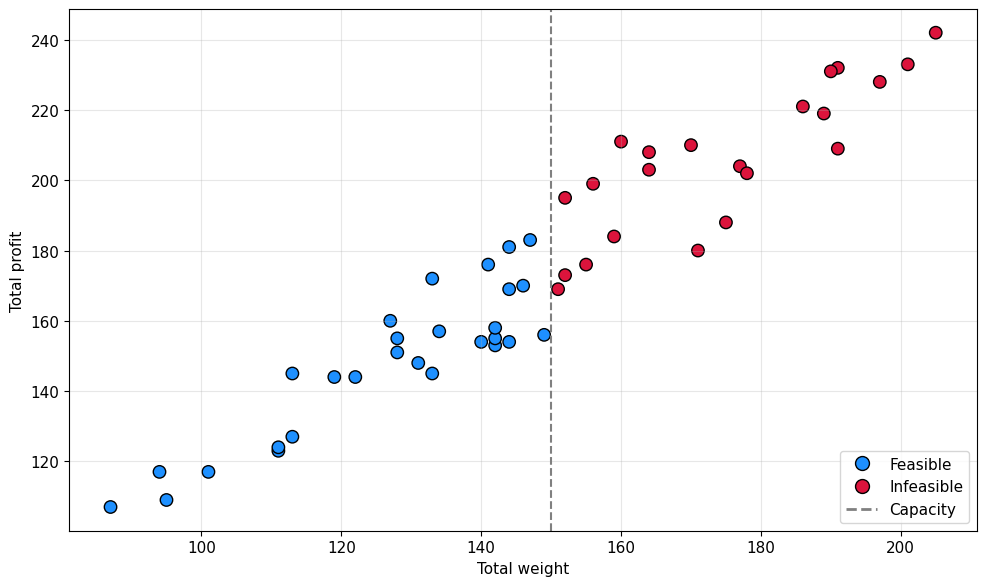

In [7]:

W = [total_weight(problem, s) for s in DivSol]
V = [objective(problem, s) for s in DivSol]
feasible = [w <= problem.capacity for w in W]

# Asigna color: azul para factibles, rojo para infeasibles
colors = ['dodgerblue' if f else 'crimson' for f in feasible]

plt.figure()
plt.scatter(W, V, c=colors, s=80, edgecolors='black', label='Pool Solutions')
plt.axvline(problem.capacity, linestyle='--', color='gray', label='Capacity')

plt.xlabel('Total weight')
plt.ylabel('Total profit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Feasible', markerfacecolor='dodgerblue', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Infeasible', markerfacecolor='crimson', markeredgecolor='black', markersize=10),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Capacity')
]
plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

## 2) Two-Phase Improvement Method

The **Two-Phase Improvement Method** is a fundamental component of Scatter Search that transforms any trial solution (potentially infeasible) into a high-quality, feasible solution using systematic local search. This ensures all solutions in the algorithm meet problem constraints while maximizing solution quality.

### Theoretical Foundation

The method implements a **greedy repair-and-improve strategy** based on efficiency analysis:
- **Efficiency metric**: Profit-to-weight ratio guides all decisions
- **Monotonic improvement**: Each phase guarantees non-decreasing solution quality
- **Constraint satisfaction**: Phase 1 ensures feasibility, Phase 2 maintains it
- **Local optimality**: Final solutions are locally optimal with respect to single-item swaps

### Phase 1: Feasibility Repair

**Objective**: Transform infeasible solutions to satisfy the capacity constraint with minimal quality loss

**Algorithm**:
1. **Efficiency ordering**: Sort items by profit/weight ratio in ascending order (worst efficiency first)
2. **Selective removal**: For each item in efficiency order:
   - If solution is still infeasible AND item is currently selected
   - Remove item (set from 1→0) and update objective value
   - Stop when solution becomes feasible
3. **Guaranteed termination**: Continue until feasibility is achieved

**Key Properties**:
- **Minimal quality loss**: Removes least valuable items first (by efficiency)
- **Guaranteed feasibility**: Always produces a feasible solution
- **Efficiency preservation**: Retains highest-efficiency items when possible

### Phase 2: Greedy Improvement

**Objective**: Maximize solution quality while maintaining feasibility constraints

**Algorithm**:
1. **Efficiency ordering**: Sort items by profit/weight ratio in descending order (best efficiency first)
2. **Selective addition**: For each item in efficiency order:
   - If item is not currently selected AND adding it maintains feasibility
   - Add item (set from 0→1) and update objective value
3. **Saturation point**: Continue until no more items can be added

**Key Properties**:
- **Quality maximization**: Adds most valuable items first (by efficiency)
- **Feasibility preservation**: Never violates capacity constraints
- **Greedy optimality**: Achieves locally optimal solution for single-item additions

### Implementation Variants

**`repair_solution(pb, x)`**: Applies only Phase 1
- Use when preserving solution diversity is important
- Faster execution for applications requiring only feasibility
- Maintains structural similarity to original solution

**`improve_solution(pb, x)`**: Applies both Phase 1 and Phase 2
- Use for maximum solution quality
- Standard choice for most Scatter Search applications
- Produces locally optimal feasible solutions

**`improvement_trace(pb, x)`**: Records complete optimization trajectory
- Captures (weight, value) points at each step
- Essential for visualization and algorithm analysis
- Useful for understanding improvement dynamics

### Complexity Analysis

- **Time complexity**: O(n log n) for sorting + O(n) for both phases = O(n log n)
- **Space complexity**: O(n) for solution storage and efficiency arrays
- **Deterministic**: Always produces the same result for identical inputs

### Strategic Benefits

**Solution Quality**: Transforms arbitrary solutions into high-quality, locally optimal solutions  
**Constraint Handling**: Guarantees feasibility while preserving solution structure where possible  
**Algorithm Integration**: Provides consistent, reliable solution improvement for metaheuristics  
**Educational Value**: Clear, interpretable optimization steps ideal for understanding greedy algorithms

### Implementation

In [8]:
def repair_solution(pb: KnapsackProblem, x: List[int]) -> Tuple[List[int], int]:
    """
    Apply feasibility repair phase to make solution satisfy capacity constraint.
    
    This function implements Phase 1 of the two-phase improvement method, removing
    items with the worst profit/weight ratios until the solution becomes feasible.
    
    Args:
        pb: KnapsackProblem instance containing problem data
        x: Binary solution vector to repair (may be infeasible)
        
    Returns:
        Tuple of (repaired_solution, objective_value):
        - repaired_solution: Feasible binary solution 
        - objective_value: Total profit of the repaired solution
        
    Raises:
        ValueError: If input solution has incorrect length
        TypeError: If solution contains non-binary values
        
    Algorithm:
        1. Sort items by efficiency (profit/weight ratio) in ascending order
        2. Remove selected items with worst efficiency until feasible
        3. Guarantee feasibility by continuing removal if necessary
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [5, 8, 6], 10)
        >>> x = [1, 1, 1]  # Infeasible: weight = 19 > 10
        >>> repaired, value = repair_solution(pb, x)
        >>> is_feasible(pb, repaired)
        True
    """
    # Input validation
    if len(x) != pb.n:
        raise ValueError(f"Solution length {len(x)} doesn't match problem size {pb.n}")
    
    if not all(xi in {0, 1} for xi in x):
        raise TypeError("Solution must contain only binary values (0 or 1)")
    
    # Create working copy and initialize objective
    repaired_solution = x[:]
    current_value = objective(pb, repaired_solution)
    
    # Get items sorted by efficiency (worst first for removal)
    efficiency_order_asc = ratio_order(pb, ascending=True)
    
    # Phase 1: Remove worst efficiency items until feasible
    items_removed = []
    for item_idx in efficiency_order_asc:
        # Check if solution is already feasible
        if is_feasible(pb, repaired_solution):
            break
            
        # Remove item if it's currently selected
        if repaired_solution[item_idx] == 1:
            repaired_solution[item_idx] = 0
            current_value -= pb.profits[item_idx]
            items_removed.append(item_idx)
    
    # Safety check: ensure feasibility (should not be needed with correct algorithm)
    fallback_removals = 0
    max_fallback_attempts = pb.n
    
    while not is_feasible(pb, repaired_solution) and fallback_removals < max_fallback_attempts:
        # Find any remaining selected item to remove
        for item_idx in range(pb.n):
            if repaired_solution[item_idx] == 1:
                repaired_solution[item_idx] = 0
                current_value -= pb.profits[item_idx]
                items_removed.append(item_idx)
                fallback_removals += 1
                break
        else:
            # No items left to remove - solution should be feasible (empty solution)
            break
    
    # Verify final feasibility
    if not is_feasible(pb, repaired_solution):
        raise RuntimeError("Failed to repair solution to feasibility")
    
    return repaired_solution, current_value

def improve_solution(pb: KnapsackProblem, x: List[int]) -> Tuple[List[int], int]:
    """
    Apply two-phase improvement method to create high-quality feasible solution.
    
    This function implements the complete two-phase improvement:
    Phase 1: Remove items with worst profit/weight ratios until feasible
    Phase 2: Add items with best profit/weight ratios while maintaining feasibility
    
    Args:
        pb: KnapsackProblem instance containing problem data
        x: Binary solution vector to improve (may be infeasible)
        
    Returns:
        Tuple of (improved_solution, objective_value):
        - improved_solution: High-quality feasible binary solution
        - objective_value: Total profit of the improved solution
        
    Raises:
        ValueError: If input solution has incorrect length
        TypeError: If solution contains non-binary values
        
    Algorithm:
        1. Phase 1 (Repair): Remove worst efficiency items until feasible
        2. Phase 2 (Improve): Add best efficiency items while maintaining feasibility
        
    Properties:
        - Always returns a feasible solution
        - Resulting solution is locally optimal for single-item additions
        - Deterministic: same input always produces same output
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [5, 8, 6], 10)
        >>> x = [1, 1, 1]  # Infeasible solution
        >>> improved, value = improve_solution(pb, x)
        >>> is_feasible(pb, improved)
        True
    """
    # Input validation
    if len(x) != pb.n:
        raise ValueError(f"Solution length {len(x)} doesn't match problem size {pb.n}")
    
    if not all(xi in {0, 1} for xi in x):
        raise TypeError("Solution must contain only binary values (0 or 1)")
    
    # Phase 1: Repair to feasibility
    improved_solution, current_value = repair_solution(pb, x)
    
    # Get items sorted by efficiency (best first for addition)
    efficiency_order_desc = ratio_order(pb, ascending=False)
    
    # Phase 2: Greedy improvement while maintaining feasibility
    items_added = []
    for item_idx in efficiency_order_desc:
        # Skip if item is already selected
        if improved_solution[item_idx] == 1:
            continue
            
        # Check if adding this item maintains feasibility
        new_weight = total_weight(pb, improved_solution) + pb.weights[item_idx]
        if new_weight <= pb.capacity:
            # Add item and update value
            improved_solution[item_idx] = 1
            current_value += pb.profits[item_idx]
            items_added.append(item_idx)
    
    # Verify final solution properties
    if not is_feasible(pb, improved_solution):
        raise RuntimeError("Improvement process violated feasibility")
    
    if current_value != objective(pb, improved_solution):
        raise RuntimeError("Objective value calculation error during improvement")
    
    return improved_solution, current_value

def improvement_trace(pb: KnapsackProblem, x: List[int]) -> Tuple[List[Tuple[int, int]], List[List[int]], Dict[str, any]]:
    """
    Track the complete solution trajectory through both improvement phases.
    
    Records detailed information about each step of the improvement process,
    including (weight, value) points, solution snapshots, and operation metadata.
    
    Args:
        pb: KnapsackProblem instance containing problem data
        x: Initial solution vector (may be infeasible)
        
    Returns:
        Tuple of (trajectory_points, solution_snapshots, trace_info):
        - trajectory_points: List of (weight, value) tuples showing optimization path
        - solution_snapshots: List of solution vectors at each step
        - trace_info: Dictionary with detailed trace metadata
        
    Raises:
        ValueError: If input solution has incorrect length
        TypeError: If solution contains non-binary values
        
    Trace Information:
        - Phase boundaries and operation counts
        - Items removed/added with their efficiency ratios
        - Performance metrics and improvement statistics
        
    Example:
        >>> pb = KnapsackProblem([10, 20, 30], [5, 8, 6], 10)
        >>> x = [1, 1, 1]  # Infeasible solution
        >>> points, snapshots, info = improvement_trace(pb, x)
        >>> len(points) >= 2  # At least initial and final points
        True
    """
    # Input validation
    if len(x) != pb.n:
        raise ValueError(f"Solution length {len(x)} doesn't match problem size {pb.n}")
    
    if not all(xi in {0, 1} for xi in x):
        raise TypeError("Solution must contain only binary values (0 or 1)")
    
    # Initialize trace data structures
    trajectory_points = []
    solution_snapshots = []
    
    # Record initial state
    current_solution = x[:]
    current_value = objective(pb, current_solution)
    current_weight = total_weight(pb, current_solution)
    
    trajectory_points.append((current_weight, current_value))
    solution_snapshots.append(current_solution[:])
    
    # Initialize trace metadata
    trace_info = {
        'initial_feasible': is_feasible(pb, x),
        'initial_value': current_value,
        'initial_weight': current_weight,
        'phase_1_operations': [],
        'phase_2_operations': [],
        'efficiency_ratios': pb.efficiency_ratios.tolist()
    }
    
    # Phase 1: Feasibility Repair (with tracing)
    efficiency_order_asc = ratio_order(pb, ascending=True)
    
    phase_1_start_idx = len(trajectory_points) - 1
    
    for item_idx in efficiency_order_asc:
        # Check if solution is already feasible
        if is_feasible(pb, current_solution):
            break
            
        # Remove item if it's currently selected
        if current_solution[item_idx] == 1:
            current_solution[item_idx] = 0
            current_value -= pb.profits[item_idx]
            current_weight = total_weight(pb, current_solution)
            
            # Record operation
            operation_info = {
                'item_idx': item_idx,
                'action': 'remove',
                'profit': pb.profits[item_idx],
                'weight': pb.weights[item_idx],
                'efficiency': pb.efficiency_ratios[item_idx],
                'new_value': current_value,
                'new_weight': current_weight,
                'feasible_after': is_feasible(pb, current_solution)
            }
            trace_info['phase_1_operations'].append(operation_info)
            
            # Record trajectory point and snapshot
            trajectory_points.append((current_weight, current_value))
            solution_snapshots.append(current_solution[:])
    
    # Safety fallback for repair (should rarely be needed)
    fallback_operations = 0
    while not is_feasible(pb, current_solution) and fallback_operations < pb.n:
        for item_idx in range(pb.n):
            if current_solution[item_idx] == 1:
                current_solution[item_idx] = 0
                current_value -= pb.profits[item_idx]
                current_weight = total_weight(pb, current_solution)
                
                operation_info = {
                    'item_idx': item_idx,
                    'action': 'remove_fallback',
                    'profit': pb.profits[item_idx],
                    'weight': pb.weights[item_idx],
                    'efficiency': pb.efficiency_ratios[item_idx],
                    'new_value': current_value,
                    'new_weight': current_weight,
                    'feasible_after': is_feasible(pb, current_solution)
                }
                trace_info['phase_1_operations'].append(operation_info)
                
                trajectory_points.append((current_weight, current_value))
                solution_snapshots.append(current_solution[:])
                fallback_operations += 1
                break
        else:
            break
    
    # Phase 2: Greedy Improvement (with tracing)
    efficiency_order_desc = ratio_order(pb, ascending=False)
    
    phase_2_start_idx = len(trajectory_points) - 1
    
    for item_idx in efficiency_order_desc:
        # Skip if item is already selected
        if current_solution[item_idx] == 1:
            continue
            
        # Check if adding this item maintains feasibility
        potential_weight = current_weight + pb.weights[item_idx]
        if potential_weight <= pb.capacity:
            # Add item
            current_solution[item_idx] = 1
            current_value += pb.profits[item_idx]
            current_weight = potential_weight
            
            # Record operation
            operation_info = {
                'item_idx': item_idx,
                'action': 'add',
                'profit': pb.profits[item_idx],
                'weight': pb.weights[item_idx],
                'efficiency': pb.efficiency_ratios[item_idx],
                'new_value': current_value,
                'new_weight': current_weight,
                'weight_utilization': current_weight / pb.capacity
            }
            trace_info['phase_2_operations'].append(operation_info)
            
            # Record trajectory point and snapshot
            trajectory_points.append((current_weight, current_value))
            solution_snapshots.append(current_solution[:])
    
    # Finalize trace metadata
    trace_info.update({
        'final_feasible': is_feasible(pb, current_solution),
        'final_value': current_value,
        'final_weight': current_weight,
        'value_improvement': current_value - trace_info['initial_value'],
        'weight_change': current_weight - trace_info['initial_weight'],
        'phase_1_steps': len(trace_info['phase_1_operations']),
        'phase_2_steps': len(trace_info['phase_2_operations']),
        'total_steps': len(trajectory_points) - 1,
        'phase_1_range': (phase_1_start_idx, phase_2_start_idx),
        'phase_2_range': (phase_2_start_idx, len(trajectory_points) - 1)
    })
    
    return trajectory_points, solution_snapshots, trace_info

def analyze_improvement_performance(pb: KnapsackProblem, solutions: List[List[int]]) -> Dict[str, any]:
    """
    Analyze improvement method performance across multiple solutions.
    
    Args:
        pb: KnapsackProblem instance
        solutions: List of solutions to analyze
        
    Returns:
        Dictionary containing performance statistics
    """
    if not solutions:
        return {'error': 'No solutions provided'}
    
    repair_stats = []
    improve_stats = []
    
    for sol in solutions:
        # Test repair method
        try:
            repaired, repair_value = repair_solution(pb, sol)
            repair_stats.append({
                'initial_feasible': is_feasible(pb, sol),
                'initial_value': objective(pb, sol),
                'repaired_value': repair_value,
                'value_change': repair_value - objective(pb, sol),
                'repair_success': is_feasible(pb, repaired)
            })
        except Exception as e:
            repair_stats.append({'error': str(e)})
        
        # Test improvement method
        try:
            improved, improve_value = improve_solution(pb, sol)
            improve_stats.append({
                'initial_feasible': is_feasible(pb, sol),
                'initial_value': objective(pb, sol),
                'improved_value': improve_value,
                'value_change': improve_value - objective(pb, sol),
                'improvement_success': is_feasible(pb, improved)
            })
        except Exception as e:
            improve_stats.append({'error': str(e)})
    
    # Calculate aggregate statistics
    successful_repairs = [s for s in repair_stats if 'error' not in s and s['repair_success']]
    successful_improvements = [s for s in improve_stats if 'error' not in s and s['improvement_success']]
    
    return {
        'total_solutions': len(solutions),
        'repair_success_rate': len(successful_repairs) / len(solutions),
        'improvement_success_rate': len(successful_improvements) / len(solutions),
        'avg_repair_value_change': np.mean([s['value_change'] for s in successful_repairs]) if successful_repairs else 0,
        'avg_improvement_value_change': np.mean([s['value_change'] for s in successful_improvements]) if successful_improvements else 0,
        'repair_stats': repair_stats,
        'improvement_stats': improve_stats
    }

### Didactic Example

In [9]:
print("=== IMPROVEMENT METHOD DEMONSTRATION ===")
print("Let's trace through the improvement of an infeasible solution:\n")

# Find a demo solution: infeasible, and improvement strictly increases value after repair
demo_solution = None
for sol in DivSol:
    if not is_feasible(problem, sol):
        # Repair (Phase 1 only)
        repaired, val_repaired = repair_solution(problem, sol)
        # Improve (Phase 1 + Phase 2)
        improved, val_improved = improve_solution(problem, sol)
        # Check: improvement is feasible and strictly better than repair
        if is_feasible(problem, improved) and val_improved > val_repaired:
            demo_solution = sol
            print("Selected demo solution (infeasible, strictly improvable):", demo_solution)
            break

# Fallback: all-ones solution
if demo_solution is None:
    print("No suitable infeasible & improvable solution found in DivSol. Using all-ones solution.")
    demo_solution = [1] * problem.n

initial_weight = total_weight(problem, demo_solution)
initial_value = objective(problem, demo_solution)

print("INITIAL SOLUTION:")
print(f"  Solution: {demo_solution}")
print(f"  Weight: {initial_weight} (capacity: {problem.capacity})")
print(f"  Value: {initial_value}")
print(f"  Feasible: {is_feasible(problem, demo_solution)}")
print()

item_ratios = [(i+1, problem.profits[i]/problem.weights[i], problem.profits[i], problem.weights[i])
               for i in range(problem.n)]
item_ratios.sort(key=lambda x: x[1])  # Ascending for Phase 1

print("ITEM EFFICIENCY RANKING (profit/weight ratio):")
print("Worst ratios first (for Phase 1 - feasibility repair):")
print("Item | Ratio  | Profit | Weight | Currently Selected")
print("-----+--------+--------+--------+-------------------")
for i in range(min(8, len(item_ratios))):
    item_idx, ratio, profit, weight = item_ratios[i]
    selected = demo_solution[item_idx-1]
    status = "YES" if selected else "no"
    print(f" {item_idx:2d}  | {ratio:6.3f} |  {profit:3d}   |  {weight:3d}   |        {status}")
print("...  |   ...  |  ...   |  ...   |       ...")
print()

# Phase 1: Feasibility repair
print("PHASE 1: FEASIBILITY REPAIR")
print("Remove items starting with worst ratios until feasible:")

current_solution = demo_solution[:]
current_weight = initial_weight
current_value = initial_value
step = 1

for item_idx, ratio, profit, weight in item_ratios:
    if is_feasible(problem, current_solution):
        break
    if current_solution[item_idx-1] == 1:
        current_solution[item_idx-1] = 0
        current_weight -= weight
        current_value -= profit
        print(f"  Step {step}: Remove item {item_idx} (ratio={ratio:.3f})")
        print(f"    Weight: {current_weight} ≤ {problem.capacity} ? {current_weight <= problem.capacity}")
        print(f"    Value: {current_value}")
        step += 1
        if is_feasible(problem, current_solution):
            print(f"    ✓ Solution now FEASIBLE!")
            break

print()

# Phase 2: Greedy improvement
print("PHASE 2: GREEDY IMPROVEMENT")
print("Add items starting with best ratios while they fit:")

item_ratios.sort(key=lambda x: x[1], reverse=True)  # Descending for Phase 2

step = 1
added_any = False

for item_idx, ratio, profit, weight in item_ratios:
    if current_solution[item_idx-1] == 0:
        if current_weight + weight <= problem.capacity:
            current_solution[item_idx-1] = 1
            current_weight += weight
            current_value += profit
            print(f"  Step {step}: Add item {item_idx} (ratio={ratio:.3f})")
            print(f"    Weight: {current_weight} ≤ {problem.capacity} ✓")
            print(f"    Value: {current_value}")
            step += 1
            added_any = True

if not added_any:
    print("  No items could be added - solution already locally optimal")

print()
print("IMPROVEMENT RESULTS:")
print(f"  Initial: weight={initial_weight}, value={initial_value}, feasible={is_feasible(problem, demo_solution)}")

final_solution, final_value = improve_solution(problem, demo_solution)
final_weight = total_weight(problem, final_solution)

print(f"  Final:   weight={final_weight}, value={final_value}, feasible={is_feasible(problem, final_solution)}")
print(f"  Improvement: {final_value - initial_value} value increase")
print(f"  Weight change: {final_weight - initial_weight}")

print("\n" + "="*60)

=== IMPROVEMENT METHOD DEMONSTRATION ===
Let's trace through the improvement of an infeasible solution:

Selected demo solution (infeasible, strictly improvable): [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
INITIAL SOLUTION:
  Solution: [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
  Weight: 151 (capacity: 150)
  Value: 169
  Feasible: False

ITEM EFFICIENCY RANKING (profit/weight ratio):
Worst ratios first (for Phase 1 - feasibility repair):
Item | Ratio  | Profit | Weight | Currently Selected
-----+--------+--------+--------+-------------------
  2  |  0.720 |   18   |   25   |        YES
  3  |  0.833 |   15   |   18   |        no
 19  |  0.870 |   20   |   23   |        no
  9  |  1.000 |   19   |   19   |        no
 14  |  1.000 |   21   |   21   |        no
 15  |  1.000 |   16   |   16   |        no
 12  |  1.077 |   14   |   13   |        YES
  5  |  1.100 |   22   |   20   |        no
...  |   ...  |  ...   |  ...   |       ...

PHASE 1: FEASIBI

#### Visualization: Improvement Trajectory

This plot traces the path of a solution through both improvement phases in the weight-value space. Each numbered point represents a step in the improvement process:

- **Red points**: Over capacity (infeasible solutions during Phase 1)
- **Blue points**: Within capacity (feasible solutions)
- **Arrows**: Show the sequential trajectory from initial solution to final improved solution
- **Black dashed line**: Knapsack capacity constraint

The trajectory typically moves left (decreasing weight) during the repair phase, then right and up (increasing both weight and value) during the greedy improvement phase, following the classic two-phase pattern.

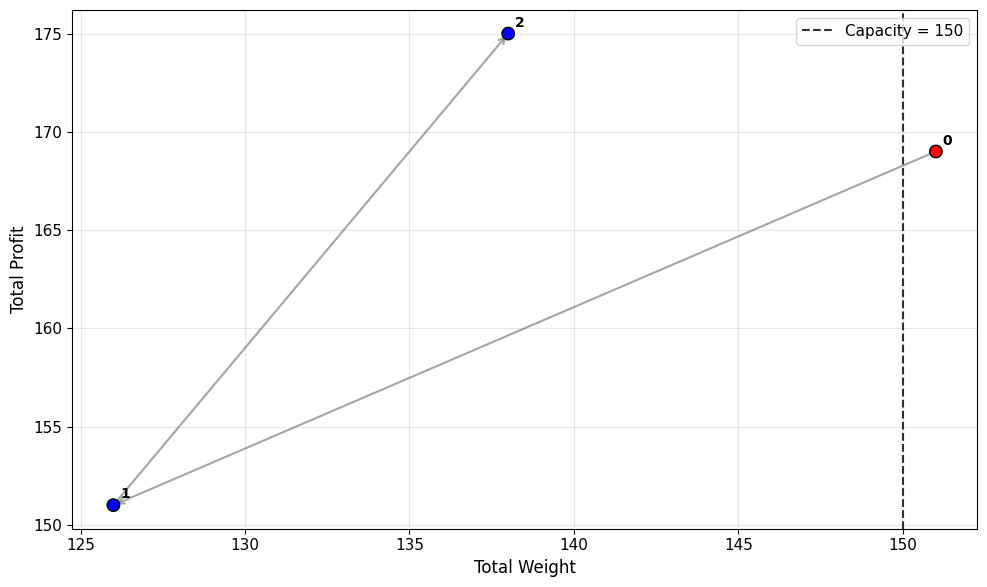

Final improved value: 175
Final improved vector: [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Trajectory points: 3
Weight progression: [151, 126, 138]
Value progression: [169, 151, 175]


In [10]:
trial = demo_solution
pts, snaps, _ = improvement_trace(problem, trial)
W_pts = [w for w, _ in pts]
V_pts = [v for _,v in pts]

plt.figure()

# Dibujar flechas entre puntos consecutivos
for i in range(len(W_pts) - 1):
    # Punto origen
    x1, y1 = W_pts[i], V_pts[i]
    # Punto destino
    x2, y2 = W_pts[i + 1], V_pts[i + 1]

    # Dibujar flecha
    plt.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='gray', alpha=0.7))

# Colorear puntos: rojo si weight > capacity, azul si weight <= capacity
colors = ['red' if w > problem.capacity else 'blue' for w in W_pts]
plt.scatter(W_pts, V_pts, c=colors, s=80, zorder=5, edgecolors='black', linewidth=1)

# Marcar cada punto con su índice
for i, (w, v) in enumerate(zip(W_pts, V_pts)):
    plt.annotate(f'{i}', (w, v), xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

# Línea vertical de capacidad
plt.axvline(problem.capacity, linestyle='--', color='black', alpha=0.8,
           label=f'Capacity = {problem.capacity}')

# plt.title('Improvement Trace (Weight vs Value)\nRed: Over capacity, Blue: Within capacity',
#           fontsize=14)
plt.xlabel('Total Weight', fontsize=12)
plt.ylabel('Total Profit', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Añadir información en el gráfico
"""
plt.text(0.02, 0.98, f'Points: {len(W_pts)}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8),
         verticalalignment='top')
"""
plt.tight_layout()
plt.show()

imp_final, val_final = improve_solution(problem, trial)
print('Final improved value:', val_final)
print('Final improved vector:', imp_final)
print(f'Trajectory points: {len(W_pts)}')
print('Weight progression:', W_pts)
print('Value progression:', V_pts)

## Build Initial Pool P

The initial pool **P** contains high-quality, feasible solutions obtained by improving each diversified solution. This pool serves as the foundation for creating the Reference Set and ensures we start with a collection of locally optimal solutions.

### Solution Addition Strategy

When building pool P, the algorithm uses an intelligent dual-phase approach to maximize diversity while maintaining solution quality:

1. **Primary Phase**: Apply full two-phase improvement (repair + optimize) to each diversified solution
2. **Backup Phase**: If full improvement creates duplicates, apply repair-only to the same candidate

### Process Details

- **Distinct solutions only**: Each unique solution appears only once in P
- **Quality priority**: Full improvement is attempted first for maximum solution quality
- **Diversity fallback**: Repair-only provides alternatives when improvement creates duplicates  
- **Target size**: Continue until reaching the specified `PSize` parameter

### Implementation

In [11]:
def build_P(pb: KnapsackProblem, DivSol: List[List[int]], PSize: int = 30) -> List[Tuple[List[int], int]]:
    """
    Build initial pool P of improved solutions from diversified solutions.
    
    Improves each solution from DivSol and maintains only distinct solutions.
    Uses dual-phase approach when needed: full improvement first, then repair-only
    for diversity when full improvement creates duplicates.
    
    Args:
        pb: KnapsackProblem instance
        DivSol: List of diversified solutions
        PSize: Target size for pool P
        
    Returns:
        List of tuples (solution, objective_value) representing pool P
    """
    improved_unique = {}
    for s in DivSol:
        s_imp, val = improve_solution(pb, s)
        key = to_tuple(s_imp)
        if key not in improved_unique:
            improved_unique[key] = (s_imp, val)
        if len(improved_unique) >= PSize:
            break
    P = list(improved_unique.values())
    
    # Ensure we have enough by augmenting if needed with improved strategies
    if len(P) < PSize:
        max_attempts = 1000  # Prevent infinite loops
        attempts = 0
        
        while len(P) < PSize and attempts < max_attempts:
            attempts += 1
            base = list(P[random.randrange(len(P))][0])
            
            # Try with full improvement first
            s_imp, val = improve_solution(pb, base)
            key = to_tuple(s_imp)
            if key not in improved_unique:
                improved_unique[key] = (s_imp, val)
                P.append((s_imp, val))
            else:
                # If solution already exists, try with repair-only
                s_repair, val_repair = repair_solution(pb, base)
                key_repair = to_tuple(s_repair)
                if key_repair not in improved_unique:
                    improved_unique[key_repair] = (s_repair, val_repair)
                    P.append((s_repair, val_repair))
    
        # If we still don't have enough unique solutions, pad with best duplicates
        if len(P) < PSize:
            print(f"Warning: Could only generate {len(P)} unique solutions out of {PSize} requested.")
            print("Padding with duplicates of best solutions...")
            # Sort by value and duplicate best solutions
            P_sorted = sorted(P, key=lambda x: x[1], reverse=True)
            while len(P) < PSize:
                best_idx = (len(P) - len(P_sorted)) % len(P_sorted)
                P.append(P_sorted[best_idx])
    
    return P[:PSize]

P = build_P(problem, DivSol, PSize=30)

#### Visualization: Pool P Solutions

This scatter plot displays all solutions in pool P plotted in the weight-value space. Each point represents an improved, feasible solution that could potentially be selected for the Reference Set. Note that all solutions should lie at or to the left of the red capacity line, since they have been processed through the improvement method's feasibility repair phase.

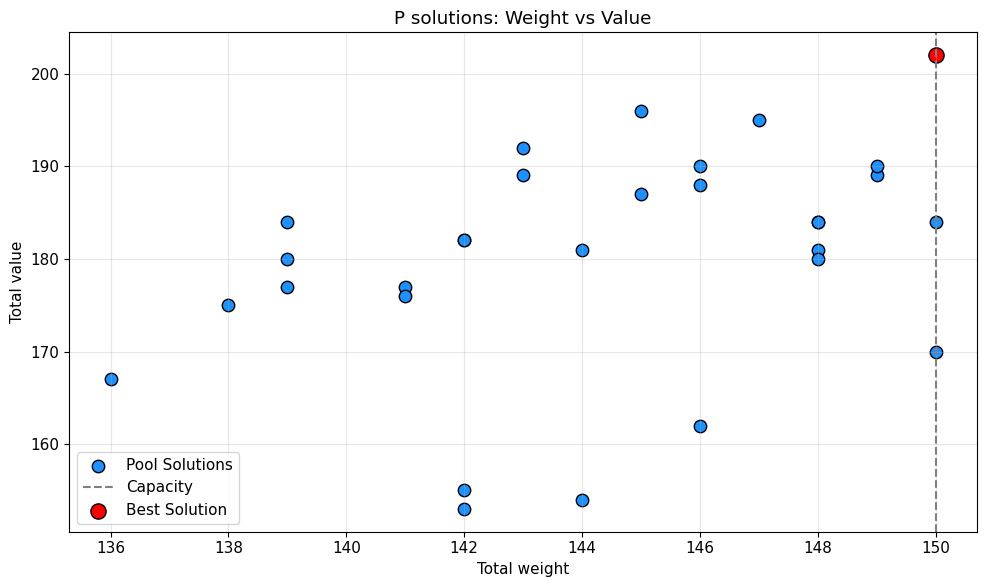

In [12]:
W = [total_weight(problem, s) for s, _ in P]
V = [v for _, v in P]

best_idx = np.argmax(V)

plt.figure()
plt.scatter(W, V, c='dodgerblue', s=80, edgecolors='black', label='Pool Solutions')
plt.axvline(problem.capacity, linestyle='--', color='gray', label='Capacity')
plt.scatter([W[best_idx]], [V[best_idx]], c='red', s=120, edgecolors='black', label='Best Solution')
plt.title('P solutions: Weight vs Value')
plt.xlabel('Total weight')
plt.ylabel('Total value')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 3) Reference Set (RefSet): Balancing Quality and Diversity

The **Reference Set** is the core memory structure of Scatter Search, maintaining a small collection of elite solutions that balance high quality with structural diversity. This balance is critical for effective search guidance and represents one of the key innovations that distinguishes Scatter Search from other metaheuristics.

### Theoretical Foundation

The RefSet implements a **dual-criteria selection strategy** that addresses the fundamental exploration vs. exploitation trade-off in optimization:

**Quality Component**: Ensures the search is guided by the best solutions found, providing **intensification**  
**Diversity Component**: Maintains structural variety to prevent premature convergence, providing **diversification**

This balance is mathematically controlled by the parameters b (total size) and b1 (quality subset size), allowing fine-tuning of the algorithm's behavior.

### RefSet Construction Strategy

The RefSet of size `b` is built using a sophisticated two-phase selection approach:

#### Phase 1: Quality Component (b1 solutions)
- **Selection Criterion**: Rank solutions by objective value, select top b1 unique solutions
- **Purpose**: Ensures RefSet contains the highest-quality discovered solutions  
- **Effect**: Provides **intensification** by focusing search around promising regions
- **Duplicate Handling**: Only unique solutions are considered (identical solutions are rejected)

#### Phase 2: Diversity Component (b2 = b - b1 solutions)
- **Selection Criterion**: Maximize minimum Hamming distance to existing RefSet members
- **Metric**: Hamming distance = number of differing bit positions between binary vectors
- **Algorithm**: Greedy selection of solutions with maximum minimum distance to RefSet
- **Purpose**: Ensures **structural diversity** and prevents premature convergence
- **Effect**: Provides **diversification** by maintaining different solution patterns

###  RefSet Algorithm

1. **Quality Phase**: Add b1 best unique solutions from pool P to RefSet
2. **Diversity Phase**: For remaining b2 positions:
   - Consider all remaining candidates from pool P (excluding duplicates)
   - For each candidate, compute minimum Hamming distance to current RefSet solutions
   - Select candidate with **maximum** minimum distance (most structurally different)
   - Apply minimum diversity threshold to ensure meaningful structural differences
   - Repeat until RefSet reaches target size `b` or no more diverse candidates available

### Advanced Features

**Validation and Robustness**:
- Comprehensive input validation and error handling
- Automatic adjustment when insufficient unique solutions are available
- Minimum diversity thresholds to ensure meaningful structural differences

**Dynamic Properties**:
- **Update flags**: Track which solutions are newly added to prioritize them in subset generation
- **Replacement mechanism**: New solutions can replace existing ones during search evolution
- **Duplicate prevention**: Identical solutions are automatically rejected to maintain diversity
- **Quality monitoring**: Real-time statistics on value ranges and diversity measures

**Analysis and Monitoring**:
- Comprehensive diversity statistics (minimum, maximum, average Hamming distances)
- Feasibility analysis of RefSet solutions
- Efficiency analysis based on profit/weight ratios
- Solution density analysis (number of selected items)

### Strategic Considerations

**Size Selection**: RefSet size `b` is typically small (5-20 solutions) to balance:
- **Computational efficiency**: Smaller sets reduce combination generation overhead
- **Solution representational power**: Larger sets capture more solution space diversity
- **Memory management**: Compact representation for efficient subset operations

**Quality/Diversity Balance**: The ratio b1/b balances intensification vs. diversification:
- Higher b1/b: More intensification (exploitation of best solutions)
- Lower b1/b: More diversification (exploration of diverse solution patterns)
- Typical values: b1 = b/2 (balanced) to b1 = 2*b/3 (quality-focused)

The RefSet serves as the algorithm's memory, guiding future search while maintaining the structural diversity necessary for effective global optimization.

### Implementation

In [13]:
@dataclass
class RefSet:
    """
    Reference Set data structure for Scatter Search algorithm.
    
    The RefSet maintains a small collection of elite solutions that balance high quality
    with structural diversity. It serves as the memory component of Scatter Search,
    guiding the search toward promising regions while maintaining exploration capability.
    
    Attributes:
        solutions: List of binary solution vectors representing selected items
        values: List of objective values corresponding to each solution
        is_new: List of boolean flags indicating newly added solutions for prioritization

    Properties:
        size: Number of solutions in the RefSet
        best_value: Highest objective value in the RefSet
        worst_value: Lowest objective value in the RefSet
        diversity_stats: Statistics about pairwise Hamming distances

    Example:
        >>> solutions = [[1, 0, 1], [0, 1, 1]]
        >>> values = [150, 120]
        >>> is_new = [True, False]
        >>> refset = RefSet(solutions, values, is_new)
        >>> refset.size
        2
    """
    solutions: List[List[int]]
    values: List[int]
    is_new: List[bool]
    types: List[str]

    def __post_init__(self):
        """Validate RefSet consistency after initialization."""
        if len(self.solutions) != len(self.values) or len(self.solutions) != len(self.is_new):
            raise ValueError(f"Inconsistent RefSet lengths: solutions={len(self.solutions)}, "
                           f"values={len(self.values)}, is_new={len(self.is_new)}")

        if len(self.solutions) == 0:
            raise ValueError("RefSet cannot be empty")

        # Check solution consistency
        if len(self.solutions) > 1:
            n = len(self.solutions[0])
            for i, sol in enumerate(self.solutions):
                if len(sol) != n:
                    raise ValueError(f"Solution {i} has length {len(sol)}, expected {n}")
                if not all(x in {0, 1} for x in sol):
                    raise ValueError(f"Solution {i} contains non-binary values")

    @property
    def size(self) -> int:
        """Number of solutions in the RefSet."""
        return len(self.solutions)

    @property
    def best_value(self) -> int:
        """Highest objective value in the RefSet."""
        return max(self.values) if self.values else 0

    @property
    def worst_value(self) -> int:
        """Lowest objective value in the RefSet."""
        return min(self.values) if self.values else 0

    @property
    def average_value(self) -> float:
        """Average objective value in the RefSet."""
        return sum(self.values) / len(self.values) if self.values else 0.0

    @property
    def new_solution_count(self) -> int:
        """Number of newly added solutions."""
        return sum(self.is_new)

    @property
    def diversity_stats(self) -> Dict[str, float]:
        """Statistics about pairwise Hamming distances between solutions."""
        if len(self.solutions) < 2:
            return {'min_distance': 0, 'max_distance': 0, 'avg_distance': 0.0}

        distances = []
        for i in range(len(self.solutions)):
            for j in range(i + 1, len(self.solutions)):
                distances.append(hamming(self.solutions[i], self.solutions[j]))

        return {
            'min_distance': min(distances),
            'max_distance': max(distances),
            'avg_distance': sum(distances) / len(distances)
        }

    def get_best_solution(self) -> Tuple[List[int], int]:
        """
        Get the best solution in the RefSet.

        Returns:
            Tuple of (best_solution, best_value)
        """
        best_idx = self.values.index(self.best_value)
        return self.solutions[best_idx][:], self.values[best_idx]

    def get_new_solutions(self) -> List[Tuple[List[int], int]]:
        """
        Get all newly added solutions.

        Returns:
            List of (solution, value) tuples for new solutions
        """
        return [(self.solutions[i][:], self.values[i])
                for i in range(len(self.solutions)) if self.is_new[i]]

    def mark_all_old(self) -> None:
        """Mark all solutions as no longer new."""
        self.is_new = [False] * len(self.is_new)

    def contains_solution(self, solution: List[int]) -> bool:
        """
        Check if a solution is already in the RefSet.

        Args:
            solution: Binary solution vector to check

        Returns:
            True if solution exists in RefSet, False otherwise
        """
        solution_tuple = to_tuple(solution)
        return any(to_tuple(sol) == solution_tuple for sol in self.solutions)

    def __str__(self) -> str:
        """Human-readable string representation."""
        return (f"RefSet(size={self.size}, values={self.values}, "
                f"new_count={self.new_solution_count}, "
                f"value_range={self.worst_value}-{self.best_value})")

def create_refset(pb: KnapsackProblem, P: List[Tuple[List[int], int]],
                 b: int = 10, b1: Optional[int] = None,
                 min_diversity: int = 1) -> RefSet:
    """
    Create Reference Set balancing quality and diversity with validation.

    Implements the two-phase RefSet construction strategy:
    1. Quality phase: Select b1 best unique solutions by objective value
    2. Diversity phase: Select b2 = b - b1 solutions maximizing minimum Hamming distance

    Args:
        pb: KnapsackProblem instance for validation
        P: Pool of candidate solutions as (solution, value) tuples
        b: Total RefSet size (must be > 0)
        b1: Number of quality-based solutions (defaults to b//2)
        min_diversity: Minimum required Hamming distance for diversity selection

    Returns:
        RefSet containing the selected solutions with all marked as new

    Raises:
        ValueError: If parameters are invalid or insufficient solutions available

    Example:
        >>> pb = KnapsackProblem([10, 20], [1, 2], 5)
        >>> P = [([1, 0], 10), ([0, 1], 20), ([1, 1], 30)]
        >>> refset = create_refset(pb, P, b=2, b1=1)
        >>> refset.size
        2
    """
    # Input validation
    if b <= 0:
        raise ValueError(f"RefSet size b must be positive, got {b}")

    if not P:
        raise ValueError("Cannot create RefSet from empty pool")

    if b1 is None:
        b1 = max(1, b // 2)  # Ensure at least 1 quality solution

    if b1 < 0 or b1 > b:
        raise ValueError(f"Invalid b1={b1}, must be between 0 and b={b}")

    b2 = b - b1

    # Validate solutions in pool
    for i, (sol, val) in enumerate(P):
        if len(sol) != pb.n:
            raise ValueError(f"Solution {i} length {len(sol)} doesn't match problem size {pb.n}")
        if not all(x in {0, 1} for x in sol):
            raise ValueError(f"Solution {i} contains non-binary values")

    # Sort pool by objective value (best first)
    P_sorted = sorted(P, key=lambda t: t[1], reverse=True)

    # Initialize RefSet components
    rs_solutions = []
    rs_values = []
    rs_types = []
    seen_solutions = set()

    # Phase 1: Quality-based selection
    selected_count = 0
    pool_index = 0

    while selected_count < b1 and pool_index < len(P_sorted):
        solution, value = P_sorted[pool_index]
        solution_tuple = to_tuple(solution)

        # Add if not duplicate
        if solution_tuple not in seen_solutions:
            rs_solutions.append(solution[:])  # Copy solution
            rs_values.append(value)
            rs_types.append('quality')
            seen_solutions.add(solution_tuple)
            selected_count += 1

        pool_index += 1

    # Check if we have enough unique solutions for quality phase
    if selected_count < b1:
        print(f"Warning: Only {selected_count} unique solutions available for quality phase (requested {b1})")
        b1 = selected_count
        b2 = b - b1

    # Phase 2: Diversity-based selection
    def min_hamming_distance_to_refset(candidate_solution: List[int]) -> int:
        """Calculate minimum Hamming distance from candidate to current RefSet."""
        if not rs_solutions:
            return 0
        return min(hamming(candidate_solution, ref_sol) for ref_sol in rs_solutions)

    # Get remaining candidates (not already in RefSet)
    remaining_candidates = [(sol, val) for sol, val in P_sorted
                          if to_tuple(sol) not in seen_solutions]

    # Select b2 most diverse solutions
    for _ in range(b2):
        if not remaining_candidates:
            break

        # Find candidate with maximum minimum distance to RefSet
        best_candidate = None
        best_distance = -1
        best_index = -1

        for i, (candidate_sol, candidate_val) in enumerate(remaining_candidates):
            min_dist = min_hamming_distance_to_refset(candidate_sol)

            if min_dist > best_distance:
                best_distance = min_dist
                best_candidate = (candidate_sol, candidate_val)
                best_index = i

        # Add best diverse candidate if it meets minimum diversity requirement
        if best_candidate is not None and best_distance >= min_diversity:
            solution, value = best_candidate
            rs_solutions.append(solution[:])
            rs_values.append(value)
            rs_types.append('diversity')
            seen_solutions.add(to_tuple(solution))

            # Remove selected candidate from remaining pool
            remaining_candidates.pop(best_index)
        else:
            # No more candidates meet diversity requirement
            break

    # Ensure we have at least some solutions
    if not rs_solutions:
        raise ValueError("Failed to create RefSet: no valid solutions found")

    # Mark all solutions as new
    is_new = [True] * len(rs_solutions)

    # Create and validate RefSet
    refset = RefSet(solutions=rs_solutions, values=rs_values, is_new=is_new, types=rs_types)
    
    return refset

def analyze_refset_quality(pb: KnapsackProblem, refset: RefSet) -> Dict[str, any]:
    """
    Comprehensive analysis of RefSet quality and diversity characteristics.
    
    Args:
        pb: KnapsackProblem instance
        refset: RefSet to analyze
        
    Returns:
        Dictionary containing detailed RefSet analysis
    """
    if refset.size == 0:
        return {'error': 'Empty RefSet'}
    
    # Basic statistics
    analysis = {
        'size': refset.size,
        'value_range': (refset.worst_value, refset.best_value),
        'value_statistics': {
            'mean': refset.average_value,
            'std': np.std(refset.values),
            'median': np.median(refset.values)
        },
        'diversity': refset.diversity_stats,
        'new_solutions': refset.new_solution_count
    }
    
    # Feasibility analysis
    feasible_count = sum(1 for sol in refset.solutions if is_feasible(pb, sol))
    analysis['feasibility'] = {
        'feasible_count': feasible_count,
        'feasible_rate': feasible_count / refset.size,
        'all_feasible': feasible_count == refset.size
    }
    
    # Efficiency analysis
    if feasible_count > 0:
        feasible_solutions = [sol for sol in refset.solutions if is_feasible(pb, sol)]
        efficiencies = []
        for sol in feasible_solutions:
            selected_items = [i for i, x in enumerate(sol) if x == 1]
            if selected_items:
                item_efficiencies = [pb.efficiency_ratios[i] for i in selected_items]
                efficiencies.append(np.mean(item_efficiencies))
        
        if efficiencies:
            analysis['efficiency'] = {
                'mean_efficiency': np.mean(efficiencies),
                'std_efficiency': np.std(efficiencies),
                'min_efficiency': min(efficiencies),
                'max_efficiency': max(efficiencies)
            }
    
    # Solution density analysis (number of selected items)
    densities = [sum(sol) for sol in refset.solutions]
    analysis['density'] = {
        'mean_density': np.mean(densities),
        'std_density': np.std(densities),
        'min_density': min(densities),
        'max_density': max(densities)
    }
    
    return analysis

### Didactic Example

In [14]:
# Ensure no repeated solutions in RefSet (quality or diversity)
print("=== REFSET CREATION DEMONSTRATION ===")
print("Let's see how RefSet balances quality and diversity (no duplicate solutions, but same values allowed):\n")

demo_pool = P

print("CANDIDATE POOL:")
print("Sol | Value | Solution (first 10 bits)")
print("----+-------+-------------------------")
for i, (sol, val) in enumerate(demo_pool):
    print(f" {i+1}  | {val:4d}  | {sol[:10]}")
print()

demo_sorted = sorted(enumerate(demo_pool), key=lambda x: x[1][1], reverse=True)

b_demo = 8  # RefSet size
b1_demo = 4  # Quality solutions

print(f"PHASE 1: SELECT {b1_demo} BEST UNIQUE SOLUTIONS (Quality component)")
print("Rank | Sol | Value | Status")
print("-----+-----+-------+--------")
refset_demo = []
refset_solutions = set()  # Store solution tuples to prevent duplicates (not values!)

quality_added = 0
rank = 0
while quality_added < b1_demo and rank < len(demo_sorted):
    orig_idx, (sol, val) = demo_sorted[rank]
    sol_tuple = to_tuple(sol)
    if sol_tuple not in refset_solutions:
        refset_demo.append((sol, val, f"Quality #{quality_added+1}"))
        refset_solutions.add(sol_tuple)
        marker = "✓ Added"
        quality_added += 1
    else:
        marker = "✗ Duplicate solution"
    print(f"  {rank+1}  | {orig_idx+1:2d}  | {val:4d}  | {marker}")
    rank += 1

print()
print(f"PHASE 2: SELECT {b_demo - len(refset_demo)} DIVERSE SOLUTIONS (Diversity component)")
print("From remaining candidates, select those maximizing minimum Hamming distance:")

remaining_candidates = [(orig_idx, sol, val) for orig_idx, (sol, val) in demo_sorted
                       if to_tuple(sol) not in refset_solutions]

for diversity_step in range(b_demo - len(refset_demo)):
    print(f"\nDiversity selection step {diversity_step + 1}:")
    if not remaining_candidates:
        print("  No more unique candidates available")
        break

    best_candidate = None
    best_min_distance = -1

    print("Candidate | Value | Min Distance to Current RefSet")
    print("----------+-------+--------------------------------")

    for cand_idx, cand_sol, cand_val in remaining_candidates:
        cand_tuple = to_tuple(cand_sol)
        if cand_tuple in refset_solutions:
            continue  # skip duplicates

        distances = [hamming(cand_sol, rs_sol) for rs_sol, _, _ in refset_demo]
        min_dist = min(distances) if distances else 0
        print(f"   Sol {cand_idx+1}  | {cand_val:3d}   | {min_dist:2d}     (distances: {distances})")

        if min_dist > best_min_distance:
            best_min_distance = min_dist
            best_candidate = (cand_idx, cand_sol, cand_val, cand_tuple)

    if best_candidate:
        cand_idx, cand_sol, cand_val, cand_tuple = best_candidate
        refset_demo.append((cand_sol, cand_val, f"Diversity (min_dist={best_min_distance})"))
        refset_solutions.add(cand_tuple)
        remaining_candidates = [(i, s, v) for i, s, v in remaining_candidates if to_tuple(s) != cand_tuple]
        print(f"  → Selected Sol {cand_idx+1} (value={cand_val}) with minimum distance {best_min_distance}")

print()
print("FINAL REFSET COMPOSITION:")
print("Pos | Type                 | Value | Solution (first 10 bits)")
print("----+----------------------+-------+-------------------------")
for i, (sol, val, sol_type) in enumerate(refset_demo):
    print(f" {i+1}  | {sol_type:20} | {val:4d}  | {sol[:10]}")

print()
print("REFSET DIVERSITY ANALYSIS:")
print("Hamming distances between RefSet solutions:")
for i in range(len(refset_demo)):
    for j in range(i+1, len(refset_demo)):
        dist = hamming(refset_demo[i][0], refset_demo[j][0])
        print(f"  Sol{i+1} ↔ Sol{j+1}: {dist} differences")

print()
print("VALUE DISTRIBUTION IN REFSET:")
value_counts = {}
for sol, val, typ in refset_demo:
    if val in value_counts:
        value_counts[val] += 1
    else:
        value_counts[val] = 1

for val, count in sorted(value_counts.items(), reverse=True):
    print(f"  Value {val}: {count} solution(s)")

avg_quality = sum(val for sol, val, typ in refset_demo) / len(refset_demo)
max_quality = max(val for sol, val, typ in refset_demo)
min_quality = min(val for sol, val, typ in refset_demo)
print(f"\nQUALITY METRICS:")
print(f"  Average RefSet value: {avg_quality:.1f}")
print(f"  Maximum RefSet value: {max_quality}")
print(f"  Minimum RefSet value: {min_quality}")

print("\n" + "="*60)

rs = create_refset(problem, P, b=b_demo, b1=b1_demo, min_diversity=1)
print(f"Created RefSet: {rs}")


=== REFSET CREATION DEMONSTRATION ===
Let's see how RefSet balances quality and diversity (no duplicate solutions, but same values allowed):

CANDIDATE POOL:
Sol | Value | Solution (first 10 bits)
----+-------+-------------------------
 1  |  181  | [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
 2  |  175  | [1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
 3  |  196  | [1, 0, 0, 0, 0, 0, 1, 1, 0, 1]
 4  |  153  | [0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
 5  |  180  | [1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
 6  |  177  | [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 7  |  155  | [0, 1, 0, 1, 1, 0, 0, 1, 0, 0]
 8  |  195  | [1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
 9  |  181  | [1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
 10  |  177  | [0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
 11  |  184  | [1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
 12  |  187  | [0, 0, 0, 1, 0, 0, 1, 0, 0, 1]
 13  |  189  | [0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
 14  |  162  | [0, 0, 1, 0, 1, 0, 0, 1, 1, 1]
 15  |  190  | [1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
 16  |  192  | [1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
 17  |  184  | [1, 0, 0, 0, 0, 1, 0, 

### Visualization: Pool P with RefSet Highlighted

This scatter plot displays all solutions in pool P, highlighting which belong to the Reference Set (blue for diversity, red for quality) versus other pool solutions (gray). The horizontal axis represents total weight, while the vertical axis represents total value. The dashed vertical line indicates the knapsack capacity constraint.

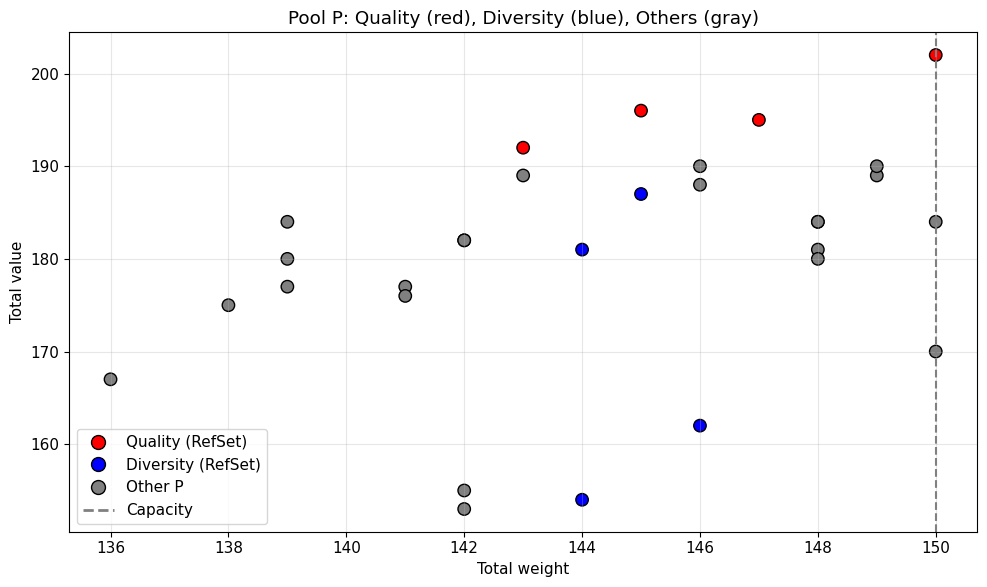

In [15]:
# Get all weights and values for P
W = [total_weight(problem, s) for s, _ in P]
V = [v for _, v in P]

# Find which P solutions are in RefSet and their type (quality/diversity)
# Assume rs has attributes: solutions (list of vectors), types (list: 'quality' or 'diversity')
# If not, you may need to reconstruct this info based on your RefSet creation logic

# Map P solutions to their indices for quick lookup
P_tuples = [to_tuple(s) for s, _ in P]
refset_tuples = [to_tuple(s) for s in rs.solutions]

# You need to know which are quality and which are diversity in RefSet
# Let's assume rs has a 'types' attribute (list of 'quality' or 'diversity')
# If not, you can reconstruct it from your RefSet creation code

def get_colors_for_pool(P, rs):
    """
    Assigns a color to each solution in P based on its presence and type in the RefSet.
    - 'red' for quality solutions in RefSet
    - 'blue' for diversity solutions in RefSet
    - 'gray' for other solutions
    """
    P_tuples = [to_tuple(s) for s, _ in P]
    refset_type_map = {to_tuple(sol): typ for sol, typ in zip(rs.solutions, rs.types)}
    colors = []
    for s_tuple in P_tuples:
        typ = refset_type_map.get(s_tuple, None)
        if typ == 'quality':
            colors.append('red')
        elif typ == 'diversity':
            colors.append('blue')
        else:
            colors.append('gray')
    return colors

colors = get_colors_for_pool(P, rs)


plt.figure()
plt.scatter(W, V, c=colors, s=80, edgecolors='black', label='Pool Solutions')
plt.axvline(problem.capacity, linestyle='--', color='gray', label='Capacity')
plt.title('Pool P: Quality (red), Diversity (blue), Others (gray)')
plt.xlabel('Total weight')
plt.ylabel('Total value')
plt.grid(True, alpha=0.3)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Quality (RefSet)', markerfacecolor='red', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Diversity (RefSet)', markerfacecolor='blue', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Other P', markerfacecolor='gray', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Capacity')
]
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()

#### Visualization: Pool P vs RefSet considering Hamming Distances to RefSet
This scatter plot displays all solutions in pool P, colored by their membership in the Reference Set (red for quality, blue for diversity, gray for others). The horizontal axis represents the minimum Hamming distance from each solution in P to any solution in the RefSet (excluding itself if present), while the vertical axis represents total value.

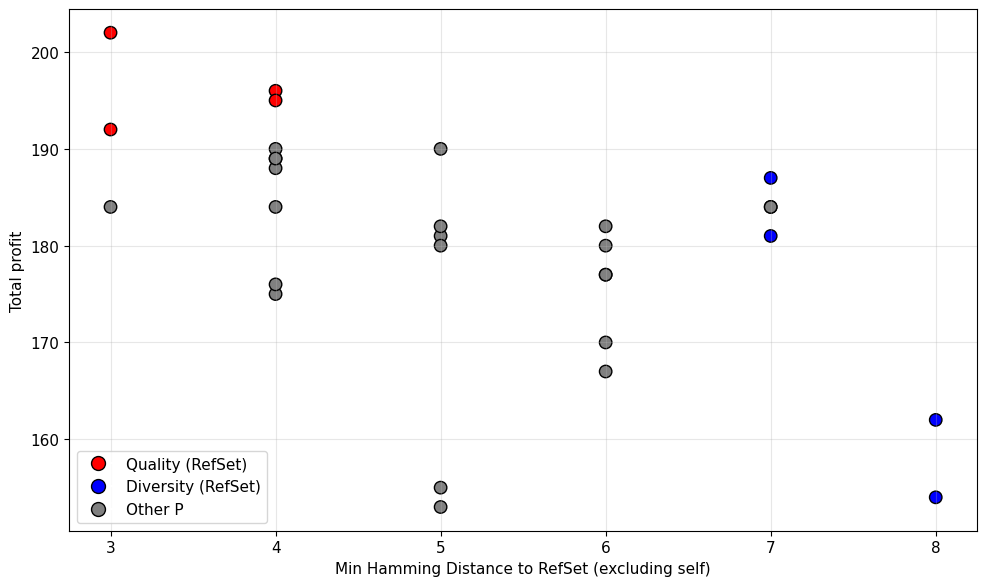

30


In [16]:
# Prepare tuples for fast comparison
P_tuples = [to_tuple(s) for s, _ in P]
refset_tuples = [to_tuple(s) for s in rs.solutions]


# Compute min Hamming distance to RefSet (excluding self if present)
min_distances = []
for i, s in enumerate(P):
    s_vec = s[0]
    s_tuple = P_tuples[i]
    # Exclude self if in RefSet
    refset_others = [r for r in rs.solutions if to_tuple(r) != s_tuple]
    if refset_others:
        dists = [hamming(s_vec, r) for r in refset_others]
        min_dist = min(dists)
    else:
        min_dist = 0
    min_distances.append(min_dist)

V = [v for _, v in P]

plt.figure()
plt.scatter(min_distances, V, c=colors, s=80, edgecolors='black')
#plt.title('Pool P: Value vs Min Distance to RefSet\nRed=Quality, Blue=Diversity, Gray=Other')
plt.xlabel('Min Hamming Distance to RefSet (excluding self)')
plt.ylabel('Total profit')
plt.grid(True, alpha=0.3)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Quality (RefSet)', markerfacecolor='red', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Diversity (RefSet)', markerfacecolor='blue', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Other P', markerfacecolor='gray', markersize=10, markeredgecolor='black'),
]
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()
print(len(P))

## 4) Subset Generation & 5) Multi-Solution Combination Method

These components work together to create new trial solutions by intelligently combining multiple RefSet solutions, extending beyond traditional pairwise combination methods.

### Subset Generation

**Strategy**: Generate subsets of various sizes from RefSet, prioritizing those containing recently added ("new") solutions.

**Process**:
- **Variable sizes**: Subset sizes range from 2 to RefSet size for exploration flexibility
- **New solution priority**: Subsets containing at least one recently added solution are generated first
- **Complementary subsets**: Additional random subsets ensure comprehensive coverage

### Multi-Solution Combination Method

**Core Innovation**: Extends traditional two-solution combination to handle arbitrarily sized subsets using a generalized weighted scoring formula.

#### Weighted Scoring Formula

For each variable position `i`, compute a score based on the quality-weighted average:

$$\text{score}(i) = \frac{\sum_{j \in \text{subset}} x_i^{(j)} \cdot \text{ObjVal}(j)}{\sum_{j \in \text{subset}} \text{ObjVal}(j)}$$

**Interpretation**: Higher-quality solutions have more influence on each variable's score.

#### Trial Generation

1. **Score computation**: Calculate weighted score for each variable position using the formula above
2. **Threshold selection**: Choose random threshold `r ∈ (0,1)` for each trial
3. **Binary assignment**: Set `x_i = 1` if `score(i) ≥ r`, else `x_i = 0`
4. **Multiple trials**: Generate several trials per subset using different thresholds

### Key Advantages

- **Scalable combination**: Works with 2, 3, or more parent solutions seamlessly
- **Quality weighting**: Better solutions contribute more to offspring characteristics
- **Increased diversity**: Larger subsets create more varied recombination patterns
- **Adaptive exploration**: Variable subset sizes prevent algorithmic stagnation

### Implementation

In [17]:
def generate_subsets(rs: RefSet, min_size: int = 2, max_size: Optional[int] = None) -> List[List[int]]:
    """
    Generate subsets of RefSet indices with variable sizes, prioritizing new solutions.
    
    Creates combinations of RefSet solution indices for the combination method,
    giving priority to subsets containing recently added (new) solutions.
    
    Args:
        rs: RefSet containing solutions and new flags
        min_size: Minimum subset size (must be >= 2)
        max_size: Maximum subset size (defaults to RefSet size)
        
    Returns:
        List of subsets, where each subset is a list of RefSet indices
        
    Raises:
        ValueError: If parameters are invalid or RefSet is too small
    """
    # Input validation
    if min_size < 2:
        raise ValueError("Minimum subset size must be at least 2")
    if len(rs.solutions) < min_size:
        raise ValueError(f"RefSet size ({len(rs.solutions)}) is smaller than minimum subset size ({min_size})")
    
    if max_size is None:
        max_size = len(rs.solutions)
    max_size = min(max_size, len(rs.solutions))
    
    if max_size < min_size:
        raise ValueError(f"Maximum size ({max_size}) cannot be less than minimum size ({min_size})")
    
    idx = list(range(len(rs.solutions)))
    new_idx = [i for i in idx if rs.is_new[i]]
    subsets = []
    
    # Priority Phase: Generate subsets containing at least one new solution
    if new_idx:
        for subset_size in range(min_size, max_size + 1):
            # For each new solution, create subsets including it
            for new_sol in new_idx:
                remaining = [i for i in idx if i != new_sol]
                
                # Generate combinations of appropriate size
                if len(remaining) >= subset_size - 1:
                    # Limit combinations to avoid exponential explosion
                    max_combinations = min(10, math.comb(len(remaining), subset_size - 1))
                    combinations_generated = 0
                    
                    for combo in itertools.combinations(remaining, subset_size - 1):
                        if combinations_generated >= max_combinations:
                            break
                        subset = sorted([new_sol] + list(combo))
                        if subset not in subsets:
                            subsets.append(subset)
                            combinations_generated += 1
    
    # Complementary Phase: Add random subsets for comprehensive coverage
    target_subsets = min(25, len(subsets) + 10)  # Reasonable upper bound
    max_attempts = 50  # Prevent infinite loops
    attempts = 0
    
    while len(subsets) < target_subsets and attempts < max_attempts:
        attempts += 1
        subset_size = random.randint(min_size, max_size)
        subset = sorted(random.sample(idx, subset_size))
        
        if subset not in subsets:
            subsets.append(subset)
    
    # Ensure diversity by including systematic subsets if few were generated
    if len(subsets) < 5 and len(rs.solutions) >= min_size:
        for size in range(min_size, min(max_size + 1, min_size + 3)):
            for combo in itertools.combinations(idx, size):
                if len(subsets) >= target_subsets:
                    break
                subset = sorted(list(combo))
                if subset not in subsets:
                    subsets.append(subset)
    
    return subsets


def combine_multiple(pb: KnapsackProblem, solutions: List[List[int]], values: List[int], 
                    n_trials: int = 3, r: Optional[float] = None, 
                    diversity_bias: float = 0.1) -> List[List[int]]:
    """
    Combine multiple solutions using weighted average scoring method.
    
    Computes quality-weighted scores for each variable based on parent solution values,
    then generates diverse trial solutions using adaptive thresholds and diversity bias.
    
    Args:
        pb: KnapsackProblem instance
        solutions: List of parent solutions to combine (minimum 2)
        values: Objective values of parent solutions
        n_trials: Number of trial solutions to generate
        r: Fixed threshold for trial generation (if None, uses adaptive thresholds)
        diversity_bias: Random noise factor to increase diversity (0.0 to 1.0)
        
    Returns:
        List of trial solutions generated from weighted combination
        
    Raises:
        ValueError: If inputs are invalid or inconsistent
    """
    # input validation
    if len(solutions) != len(values):
        raise ValueError(f"Mismatched lengths: {len(solutions)} solutions vs {len(values)} values")
    if len(solutions) < 2:
        raise ValueError("Need at least 2 solutions for combination")
    if not all(len(sol) == pb.n for sol in solutions):
        raise ValueError("All solutions must have same length as problem size")
    if n_trials < 1:
        raise ValueError("Number of trials must be positive")
    if not (0.0 <= diversity_bias <= 1.0):
        raise ValueError("Diversity bias must be between 0.0 and 1.0")
    
    # Handle edge cases for values
    total_value = sum(max(0, v) for v in values)  # Ensure non-negative weights
    if total_value == 0:
        # If all values are zero or negative, use uniform weights
        weights = [1.0 / len(values)] * len(values)
    else:
        weights = [max(0, v) / total_value for v in values]
    
    # Compute quality-weighted scores for each variable
    scores = []
    for i in range(pb.n):
        weighted_sum = sum(solutions[j][i] * weights[j] for j in range(len(solutions)))
        # Add small diversity bias to prevent deterministic behavior
        noise = random.uniform(-diversity_bias, diversity_bias) if diversity_bias > 0 else 0
        score = max(0.0, min(1.0, weighted_sum + noise))  # Clamp to [0,1]
        scores.append(score)
    
    # Generate trial solutions using adaptive thresholds
    trials = []
    for trial_idx in range(n_trials):
        if r is None:
            # Adaptive threshold based on trial index and score distribution
            base_threshold = 0.3 + 0.4 * (trial_idx / max(1, n_trials - 1))  # Range [0.3, 0.7]
            score_variance = np.var(scores) if len(scores) > 1 else 0.1
            threshold_noise = random.uniform(-score_variance, score_variance)
            threshold = max(0.1, min(0.9, base_threshold + threshold_noise))
        else:
            threshold = float(r)
        
        # Generate trial solution
        trial = [1 if scores[i] >= threshold else 0 for i in range(pb.n)]
        
        # Ensure trial is not empty or full (basic feasibility check)
        if sum(trial) == 0:
            # If empty, randomly set some high-score variables
            high_score_indices = [i for i, s in enumerate(scores) if s > 0.5]
            if high_score_indices:
                trial[random.choice(high_score_indices)] = 1
        elif sum(trial) == pb.n:
            # If full, randomly unset some low-score variables
            low_score_indices = [i for i, s in enumerate(scores) if s < 0.5]
            if low_score_indices:
                trial[random.choice(low_score_indices)] = 0
        
        trials.append(trial)
    
    # Remove duplicate trials
    unique_trials = []
    for trial in trials:
        if trial not in unique_trials:
            unique_trials.append(trial)
    
    return unique_trials


def combine_two(pb: KnapsackProblem, s1: List[int], v1: int, s2: List[int], v2: int, 
               n_trials: int = 3, r: Optional[float] = None) -> List[List[int]]:
    """
    Legacy function for combining exactly two solutions.
    
    Maintained for backward compatibility - internally uses multi-solution method.
    
    Args:
        pb: KnapsackProblem instance
        s1: First parent solution
        v1: Objective value of first solution
        s2: Second parent solution  
        v2: Objective value of second solution
        n_trials: Number of trials to generate
        r: Fixed threshold (if None, uses adaptive thresholds)
        
    Returns:
        List of trial solutions
    """
    return combine_multiple(pb, [s1, s2], [v1, v2], n_trials, r)


def analyze_combination_quality(pb: KnapsackProblem, parents: List[List[int]], 
                              parent_values: List[int], trials: List[List[int]]) -> Dict[str, Any]:
    """
    Analyze the quality and diversity of solution combinations.
    
    Provides comprehensive metrics about the combination process including
    parent diversity, trial diversity, and inheritance patterns.
    
    Args:
        pb: KnapsackProblem instance
        parents: Parent solutions used for combination
        parent_values: Objective values of parent solutions
        trials: Generated trial solutions
        
    Returns:
        Dictionary containing detailed combination analysis
    """
    analysis = {}
    
    # Parent analysis
    if len(parents) >= 2:
        parent_distances = []
        for i in range(len(parents)):
            for j in range(i + 1, len(parents)):
                distance = hamming(parents[i], parents[j])
                parent_distances.append(distance)

        analysis['parent_diversity'] = {
            'min_distance': min(parent_distances) if parent_distances else 0,
            'max_distance': max(parent_distances) if parent_distances else 0,
            'avg_distance': np.mean(parent_distances) if parent_distances else 0,
            'total_pairs': len(parent_distances)
        }

    # Trial analysis
    if trials:
        trial_values = [objective(pb, trial) for trial in trials]
        trial_distances = []

        # Trial-to-trial distances
        for i in range(len(trials)):
            for j in range(i + 1, len(trials)):
                distance = hamming(trials[i], trials[j])
                trial_distances.append(distance)

        # Trial-to-parent distances
        trial_parent_distances = []
        for trial in trials:
            for parent in parents:
                distance = hamming(trial, parent)
                trial_parent_distances.append(distance)
        
        analysis['trial_quality'] = {
            'count': len(trials),
            'values': trial_values,
            'best_value': max(trial_values) if trial_values else 0,
            'avg_value': np.mean(trial_values) if trial_values else 0,
            'value_std': np.std(trial_values) if len(trial_values) > 1 else 0
        }
        
        analysis['trial_diversity'] = {
            'internal_distances': trial_distances,
            'avg_internal_distance': np.mean(trial_distances) if trial_distances else 0,
            'parent_distances': trial_parent_distances,
            'avg_parent_distance': np.mean(trial_parent_distances) if trial_parent_distances else 0
        }
        
        # Inheritance analysis
        if parents and trials:
            inheritance_ratios = []
            for trial in trials:
                inherited_bits = sum(1 for i, bit in enumerate(trial) 
                                   if any(parent[i] == bit for parent in parents))
                ratio = inherited_bits / len(trial) if len(trial) > 0 else 0
                inheritance_ratios.append(ratio)
            
            analysis['inheritance'] = {
                'ratios': inheritance_ratios,
                'avg_inheritance': np.mean(inheritance_ratios) if inheritance_ratios else 0,
                'inheritance_std': np.std(inheritance_ratios) if len(inheritance_ratios) > 1 else 0
            }
    
    return analysis

### Didactic Example

In [18]:
print("\n=== COMBINATION METHOD DEMONSTRATION ===")
print("Let's examine how the improved multi-solution combination works:\n")

# Demonstrate with multiple solutions from RefSet
demo_indices = [0, 2, 5]  # Use 3 solutions for multi-solution example
demo_solutions = [rs.solutions[i] for i in demo_indices]
demo_values = [rs.values[i] for i in demo_indices]

print("PARENT SOLUTIONS FOR COMBINATION:")
for i, idx in enumerate(demo_indices):
    sol, val = demo_solutions[i], demo_values[i]
    print(f"  Parent {i+1} (RefSet[{idx}]): {sol} → Value: {val}")

print(f"\nPARENT DIVERSITY ANALYSIS:")
total_distance = 0
pair_count = 0
for i in range(len(demo_solutions)):
    for j in range(i + 1, len(demo_solutions)):
        dist = hamming(demo_solutions[i], demo_solutions[j])
        total_distance += dist
        pair_count += 1
        print(f"  Distance between Parent {i+1} and Parent {j+1}: {dist}")

avg_distance = total_distance / pair_count if pair_count > 0 else 0
print(f"  Average pairwise distance: {avg_distance:.2f}")

print(f"\nWEIGHTED SCORING COMPUTATION:")
print("For each variable position, we compute a quality-weighted score...")

# Show detailed scoring for first few variables
total_value = sum(demo_values)
for i in range(min(8, problem.n)):  # Show first 8 variables
    weighted_sum = sum(demo_solutions[j][i] * demo_values[j] for j in range(len(demo_solutions)))
    score = weighted_sum / total_value
    
    contributions = [f"({demo_solutions[j][i]} × {demo_values[j]})" for j in range(len(demo_solutions))]
    print(f"  Variable {i}: [{' + '.join(contributions)}] / {total_value} = {score:.3f}")

print(f"\nTRIAL GENERATION:")
print("Generating multiple trials using adaptive thresholds...")

# Generate trials
trials = combine_multiple(problem, demo_solutions, demo_values, n_trials=4, diversity_bias=0.1)

print(f"\nGENERATED TRIALS:")
for i, trial in enumerate(trials):
    trial_value = objective(problem, trial)
    trial_weight = sum(trial[j] * problem.weights[j] for j in range(problem.n))
    feasible = "✓" if is_feasible(problem, trial) else "✗"
    print(f"  Trial {i+1}: {trial} → Value: {trial_value}, Weight: {trial_weight}, Feasible: {feasible}")

print(f"\nCOMBINATION QUALITY ANALYSIS:")
analysis = analyze_combination_quality(problem, demo_solutions, demo_values, trials)

if 'trial_quality' in analysis:
    tq = analysis['trial_quality']
    print(f"  Trial count: {tq['count']}")
    print(f"  Best trial value: {tq['best_value']}")
    print(f"  Average trial value: {tq['avg_value']:.2f}")
    print(f"  Value standard deviation: {tq['value_std']:.2f}")

if 'trial_diversity' in analysis:
    td = analysis['trial_diversity']
    print(f"  Average trial-to-trial distance: {td['avg_internal_distance']:.2f}")
    print(f"  Average trial-to-parent distance: {td['avg_parent_distance']:.2f}")

if 'inheritance' in analysis:
    inh = analysis['inheritance']
    print(f"  Average inheritance ratio: {inh['avg_inheritance']:.2f}")
    print(f"  Inheritance diversity (std): {inh['inheritance_std']:.3f}")

print(f"\nCOMPARISON: Two-Solution vs Multi-Solution Methods")
print("Let's compare the original two-solution method with the multi-solution approach...")

# Traditional two-solution combination
two_sol_trials = combine_two(problem, demo_solutions[0], demo_values[0], 
                            demo_solutions[1], demo_values[1], n_trials=3)

print(f"\nTwo-solution trials (Parents 1 & 2 only):")
for i, trial in enumerate(two_sol_trials):
    trial_value = objective(problem, trial)
    print(f"  Trial {i+1}: Value = {trial_value}")

print(f"\nMulti-solution trials (All 3 parents):")
for i, trial in enumerate(trials[:3]):  # Compare same number
    trial_value = objective(problem, trial)
    print(f"  Trial {i+1}: Value = {trial_value}")

# Demonstrate subset generation
print(f"\n=== SUBSET GENERATION DEMONSTRATION ===")
print("Showing how subsets are generated for combination...")

subsets = generate_subsets(rs, min_size=2, max_size=4)
print(f"\nGenerated {len(subsets)} subsets for combination:")

for i, subset in enumerate(subsets[:10]):  # Show first 10
    subset_values = [rs.values[j] for j in subset]
    has_new = any(rs.is_new[j] for j in subset)
    new_indicator = " (contains NEW)" if has_new else ""
    print(f"  Subset {i+1}: Indices {subset} → Values {subset_values}{new_indicator}")

if len(subsets) > 10:
    print(f"  ... and {len(subsets) - 10} more subsets")

print(f"\nSUBSET PRIORITIES:")
new_subsets = [s for s in subsets if any(rs.is_new[j] for j in s)]
old_subsets = [s for s in subsets if not any(rs.is_new[j] for j in s)]
print(f"  Subsets with new solutions: {len(new_subsets)}")
print(f"  Subsets with only existing solutions: {len(old_subsets)}")
print(f"  Total subsets: {len(subsets)}")


=== COMBINATION METHOD DEMONSTRATION ===
Let's examine how the improved multi-solution combination works:

PARENT SOLUTIONS FOR COMBINATION:
  Parent 1 (RefSet[0]): [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0] → Value: 202
  Parent 2 (RefSet[2]): [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1] → Value: 195
  Parent 3 (RefSet[5]): [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0] → Value: 181

PARENT DIVERSITY ANALYSIS:
  Distance between Parent 1 and Parent 2: 7
  Distance between Parent 1 and Parent 3: 9
  Distance between Parent 2 and Parent 3: 8
  Average pairwise distance: 8.00

WEIGHTED SCORING COMPUTATION:
For each variable position, we compute a quality-weighted score...
  Variable 0: [(1 × 202) + (1 × 195) + (1 × 181)] / 578 = 1.000
  Variable 1: [(0 × 202) + (0 × 195) + (0 × 181)] / 578 = 0.000
  Variable 2: [(0 × 202) + (1 × 195) + (0 × 181)] / 578 = 0.337
  Variable 3: [(1 × 202) + (0 × 195) + (0 × 181)] / 578 = 0.349
  Variable 4: [(

## RefSet Update and Rebuild Mechanism

The RefSet update and rebuild processes form the heart of Scatter Search evolution, managing the balance between **intensification** and **diversification** throughout the search.

### RefSet Update Process

The update process attempts to improve the current RefSet through solution combination and improvement:

1. **Subset Generation**: Create subsets of RefSet solutions with variable sizes (2 to RefSet size)
   - **Priority**: Subsets containing recently added ("new") solutions are processed first
   - **Diversity**: Variable sizes prevent stagnation and increase exploration

2. **Solution Combination**: Apply multi-solution combination method to each subset
   - **Weighted scoring**: Compute quality-based scores for each variable across subset solutions
   - **Trial generation**: Create multiple trial solutions using different random thresholds

3. **Improvement**: Apply two-phase improvement method to each generated trial

4. **RefSet Admission**: Attempt to add improved trials to RefSet
   - **Quality replacement**: New solutions replace worst existing solutions if better
   - **Duplicate prevention**: Identical solutions are rejected to maintain diversity

### RefSet Rebuild Process

When no new solutions are added during an update iteration, the algorithm triggers a rebuild:

1. **Trigger Condition**: No improvement indicates potential convergence to a local region
2. **Fresh Diversification**: Generate completely new diverse solutions from scratch
3. **New RefSet Creation**: Build a fresh RefSet balancing quality and diversity
4. **Search Restart**: Continue exploration from new promising regions

### Strategic Benefits

- **Intensification**: Updates refine solutions around current high-quality regions
- **Diversification**: Rebuilds escape local optima by exploring new search areas
- **Adaptive Balance**: Algorithm automatically adjusts between exploitation and exploration
- **Convergence Prevention**: Rebuilds prevent premature convergence to suboptimal regions

In [19]:
def update_refset(pb: KnapsackProblem, rs: RefSet, verbose: bool = False) -> bool:
    """
    Update RefSet by generating new solutions through combination and improvement.
    
    This function implements the core RefSet update mechanism of Scatter Search:
    1. Generate subsets of RefSet solutions with priority on "new" solutions
    2. Apply multi-solution combination to create trial solutions
    3. Improve trial solutions using the enhancement method
    4. Attempt to add improved solutions to RefSet
    
    Args:
        pb: KnapsackProblem instance
        rs: RefSet to update (modified in-place)
        verbose: Print detailed information about the update process
        
    Returns:
        True if at least one new solution was added to RefSet, False otherwise
    """
    if verbose:
        print(f"=== RefSet Update ===")
        print(f"Current RefSet values: {rs.values}")
        print(f"Solutions marked as new: {sum(rs.is_new)}")

    new_solutions_added = 0
    solutions_generated = 0

    # Use the existing subset generator
    subsets = generate_subsets(rs, min_size=2, max_size=len(rs.solutions))

    if verbose:
        new_subsets = sum(1 for indices in subsets if any(rs.is_new[i] for i in indices))
        print(f"Generated {len(subsets)} subsets ({new_subsets} with new solutions)")
        for i, indices in enumerate(subsets[:3]):
            status = "NEW" if any(rs.is_new[j] for j in indices) else "old"
            subset_values = [rs.values[j] for j in indices]
            print(f"  Subset {i+1}: indices {indices}, values {subset_values} ({status})")

    for subset_idx, subset_indices in enumerate(subsets):
        if verbose and subset_idx < 2:
            print(f"\nProcessing subset {subset_idx+1}: {subset_indices}")

        subset_solutions = [rs.solutions[i] for i in subset_indices]
        subset_values = [rs.values[i] for i in subset_indices]

        # Use combine_multiple for all subset sizes
        trials = combine_multiple(pb, subset_solutions, subset_values, n_trials=3)

        solutions_generated += len(trials)

        if verbose and subset_idx < 2:
            print(f"  Generated {len(trials)} trial solutions")

        for trial_idx, trial in enumerate(trials):
            improved_trial, improved_value = improve_solution(pb, trial)
            if verbose and subset_idx < 2:
                original_value = objective(pb, trial)
                print(f"    Trial {trial_idx+1}: {original_value} -> {improved_value}")

            if attempt_refset_addition(pb, rs, improved_trial, improved_value):
                new_solutions_added += 1
                if verbose:
                    print(f"    ✓ Trial {trial_idx+1} added to RefSet (value={improved_value})")

        if new_solutions_added >= 2:
            break

    rs.is_new = [False] * len(rs.solutions)


    if verbose:
        print(f"\nUpdate completed:")
        print(f"  Solutions generated: {solutions_generated}")
        print(f"  New solutions added: {new_solutions_added}")
        print(f"  Final RefSet values: {rs.values}")
        print(f"  Final diversity: {rs.diversity_stats['avg_distance']:.2f}")

    return new_solutions_added > 0


def attempt_refset_addition(pb: KnapsackProblem, rs: RefSet, solution: List[int], value: float) -> bool:
    """
    Attempt to add a solution to the RefSet based on quality and diversity criteria.
    
    Args:
        pb: KnapsackProblem instance
        rs: RefSet to potentially add solution to
        solution: Candidate solution to add
        value: Objective value of the candidate solution
        
    Returns:
        True if solution was added to RefSet, False otherwise
    """
    # Check for duplicates
    for existing_sol in rs.solutions:
        if existing_sol == solution:
            return False  # Duplicate solution, reject
    
    # Find worst solution in RefSet
    worst_idx = int(np.argmin(rs.values))
    worst_value = rs.values[worst_idx]
    
    # Replace if new solution is better
    if value > worst_value:
        rs.solutions[worst_idx] = solution[:]
        rs.values[worst_idx] = value
        rs.is_new[worst_idx] = True  # Mark as new
        return True
    
    return False


def rebuild_refset(pb: KnapsackProblem, PSize: int = 30, b: int = 10, b1: int = 5, 
                  preserved_solution: Optional[List[int]] = None, verbose: bool = False) -> RefSet:
    """
    Rebuild RefSet from scratch using fresh diversification with optional elite preservation.
    
    Creates a completely new RefSet when the current one stops improving,
    ensuring continued exploration of the search space while optionally preserving
    the best solution found so far.
    
    Args:
        pb: KnapsackProblem instance
        PSize: Size of initial pool P
        b: RefSet size  
        b1: Number of quality-based solutions in RefSet
        preserved_solution: Optional elite solution to preserve in new RefSet
        verbose: Print detailed information about the rebuild process
        
    Returns:
        New RefSet with fresh diverse solutions
    """
    if verbose:
        print(f"=== RefSet Rebuild ===")
        print("Generating fresh diverse solutions...")
    
    # Generate fresh diverse solutions
    DivSol2 = generate_diverse_solutions(pb, target=PSize * 3, hmax=5)
    P2 = build_P(pb, DivSol2, PSize=PSize)
    
    # If elite preservation is requested, add the preserved solution to P2
    if preserved_solution is not None:
        preserved_value = objective(pb, preserved_solution)
        
        # Check if preserved solution is better than worst in P2
        P2_values = [objective(pb, sol) for sol, val in P2]
        worst_value_idx = int(np.argmin(P2_values))
        
        if preserved_value > P2_values[worst_value_idx]:
            # Replace worst solution with preserved elite
            P2[worst_value_idx] = (preserved_solution[:], preserved_value)
            if verbose:
                print(f"Elite solution preserved (value={preserved_value}) replacing worst (value={P2_values[worst_value_idx]})")
        elif verbose:
            print(f"Elite solution (value={preserved_value}) not better than worst in new population")

    new_rs = create_refset(pb, P2, b=b, b1=b1)

    
    if verbose:
        print(f"New RefSet created with values: {new_rs.values}")
        best_new = max(new_rs.values)
        print(f"Best value in new RefSet: {best_new}")
        if preserved_solution is not None:
            preserved_in_refset = any(sol == preserved_solution for sol in new_rs.solutions)
            print(f"Elite solution in new RefSet: {preserved_in_refset}")
    
    return new_rs

# Demonstrate RefSet management capabilities
print("=== REFSET UPDATE AND REBUILD DEMONSTRATION ===")

# Create a demonstration RefSet for testing
print("\nCreating demonstration RefSet...")
demo_P = build_P(problem, DivSol[:20], PSize=10)
demo_rs = create_refset(problem, demo_P, b=5, b1=2)

print(f"\nDemonstration RefSet created:")
print(f"  Size: {len(demo_rs.solutions)}")
print(f"  Values: {demo_rs.values}")
print(f"  Average diversity: {demo_rs.diversity_stats['avg_distance']:.2f}")

print(f"\nSolutions in RefSet:")
for i, (sol, val, is_new) in enumerate(zip(demo_rs.solutions, demo_rs.values, demo_rs.is_new)):
    status = "NEW" if is_new else "old"
    print(f"  Solution {i}: {sol[:8]}... value={val} ({status})")

print(f"\nRunning update with verbose output (showing first few subsets)...")
update_result = update_refset(problem, demo_rs, verbose=True)

=== REFSET UPDATE AND REBUILD DEMONSTRATION ===

Creating demonstration RefSet...

Demonstration RefSet created:
  Size: 5
  Values: [196, 195, 153, 175, 181]
  Average diversity: 9.80

Solutions in RefSet:
  Solution 0: [1, 0, 0, 0, 0, 0, 1, 1]... value=196 (NEW)
  Solution 1: [1, 0, 1, 0, 0, 1, 1, 0]... value=195 (NEW)
  Solution 2: [0, 0, 1, 1, 1, 0, 0, 0]... value=153 (NEW)
  Solution 3: [1, 0, 0, 1, 0, 1, 0, 0]... value=175 (NEW)
  Solution 4: [1, 0, 0, 0, 0, 0, 1, 0]... value=181 (NEW)

Running update with verbose output (showing first few subsets)...
=== RefSet Update ===
Current RefSet values: [196, 195, 153, 175, 181]
Solutions marked as new: 5
Generated 26 subsets (26 with new solutions)
  Subset 1: indices [0, 1], values [196, 195] (NEW)
  Subset 2: indices [0, 2], values [196, 153] (NEW)
  Subset 3: indices [0, 3], values [196, 175] (NEW)

Processing subset 1: [0, 1]
  Generated 3 trial solutions
    Trial 1: 229 -> 205
    ✓ Trial 1 added to RefSet (value=205)
    Trial 2:

In [20]:
@dataclass
class SSParams:
    """
    Scatter Search algorithm parameters with validation and documentation.

    Attributes:
        PSize: Size of improved population P (should be larger than RefSet size)
        b: Total RefSet size (balance between computational efficiency and diversity)
        b1: Number of high-quality solutions in RefSet (quality vs diversity balance)
        max_iter: Maximum iterations before forced termination
        patience: Stop if no improvement for this many consecutive iterations
        rebuild_patience: Trigger rebuild after this many iterations without improvement
        min_diversity_threshold: Minimum Hamming distance for solution admission
        combination_trials: Number of trial solutions per subset combination
        diversification_multiplier: Factor for initial diversification generation
        elite_preservation: Whether to preserve best-ever solution across rebuilds
    """
    PSize: int = 12
    b: int = 8
    b1: int = 4
    max_iter: int = 100
    patience: int = 15
    rebuild_patience: int = 5
    min_diversity_threshold: int = 1
    combination_trials: int = 3
    diversification_multiplier: int = 3
    elite_preservation: bool = True

    def __post_init__(self):
        """Validate parameter consistency."""
        if self.PSize <= 0:
            raise ValueError("PSize must be positive")
        if self.b <= 0:
            raise ValueError("RefSet size b must be positive")
        if self.b1 <= 0 or self.b1 > self.b:
            raise ValueError(f"b1 must be between 1 and b ({self.b})")
        if self.max_iter <= 0:
            raise ValueError("max_iter must be positive")
        if self.patience <= 0:
            raise ValueError("patience must be positive")
        if self.rebuild_patience <= 0:
            raise ValueError("rebuild_patience must be positive")
        if self.PSize < self.b:
            raise ValueError(f"PSize ({self.PSize}) should be >= RefSet size ({self.b})")


def run_scatter_search(pb: KnapsackProblem, params: SSParams, verbose: bool = False) -> Dict[str, Any]:
    """
    Execute Scatter Search algorithm with comprehensive tracking and adaptive mechanisms.

    This implementation provides a robust, well-documented Scatter Search algorithm with
    extensive error handling, performance tracking, and adaptive search mechanisms.

    Args:
        pb: KnapsackProblem instance to optimize
        params: SSParams containing algorithm configuration
        verbose: Enable detailed progress reporting

    Returns:
        Comprehensive results dictionary containing:
        - best_value: Objective value of best solution found
        - best_solution: Best solution vector
        - best_iteration: Iteration when best solution was found
        - history: Best value evolution per iteration
        - refset_final: Final RefSet state
        - statistics: Detailed algorithm performance metrics
        - convergence_info: Analysis of convergence behavior

    Raises:
        ValueError: If parameters are invalid or problem is malformed
        RuntimeError: If algorithm encounters unexpected errors
    """
    # Input validation
    if pb.n <= 0:
        raise ValueError("Problem must have at least one item")
    if pb.capacity <= 0:
        raise ValueError("Knapsack capacity must be positive")

    # Initialize tracking structures
    search_stats = {
        'iterations_completed': 0,
        'rebuilds_performed': 0,
        'solutions_generated': 0,
        'solutions_improved': 0,
        'refset_updates': 0,
        'elite_solutions_found': 0,
        'start_time': None,
        'end_time': None
    }

    convergence_history = {
        'best_values': [],
        'rebuild_iterations': [],
        'improvement_iterations': [],
        'refset_diversity': [],
        'computation_times': []
    }

    if verbose:
        print("=== SCATTER SEARCH ALGORITHM ===")
        print(f"Problem: {pb.n} items, capacity {pb.capacity}")
        print(f"Parameters: PSize={params.PSize}, RefSet=({params.b1}+{params.b-params.b1}={params.b})")
        print(f"Termination: max_iter={params.max_iter}, patience={params.patience}")


    search_stats['start_time'] = time.time()

    try:
        # Phase 1: Initial Diversification
        if verbose:
            print(f"\n--- Phase 1: Initial Diversification ---")

        initial_target = params.PSize * params.diversification_multiplier
        DivSol0 = generate_diverse_solutions(pb, target=initial_target, hmax=min(8, pb.n-1))
        search_stats['solutions_generated'] += len(DivSol0)

        if verbose:
            feasible_count = sum(1 for sol in DivSol0 if is_feasible(pb, sol))
            print(f"Generated {len(DivSol0)} diverse solutions ({feasible_count} feasible)")

        # Phase 2: Population Building with Comprehensive Improvement
        if verbose:
            print(f"\n--- Phase 2: Population Improvement ---")

        P0 = build_P(pb, DivSol0, PSize=params.PSize)
        search_stats['solutions_improved'] += len(P0)

        if verbose:
            p_values = [objective(pb, sol) for sol, val in P0]
            print(f"Improved population P: {len(P0)} solutions")
            print(f"Value range: {min(p_values)} - {max(p_values)} (avg: {np.mean(p_values):.1f})")

        # Phase 3: Initial RefSet Construction
        if verbose:
            print(f"\n--- Phase 3: RefSet Construction ---")

        rs = create_refset(pb, P0, b=params.b, b1=params.b1)
        search_stats['refset_updates'] += 1

        # Initialize best solution tracking
        best_val = max(rs.values)
        best_sol = rs.solutions[int(np.argmax(rs.values))][:]
        best_iteration = 0
        global_best_val = best_val
        global_best_sol = best_sol[:]

        # Initialize convergence tracking
        convergence_history['best_values'].append(best_val)
        convergence_history['refset_diversity'].append(rs.diversity_stats['avg_distance'])

        if verbose:
            print(f"Initial RefSet values: {rs.values}")
            print(f"Initial best solution: value={best_val}, diversity={rs.diversity_stats['avg_distance']:.2f}")

        # Phase 4: Main Search Loop
        if verbose:
            print(f"\n--- Phase 4: Iterative Search ---")

        no_improvement_count = 0
        rebuild_count = 0
        last_rebuild = -params.rebuild_patience

        for iteration in range(params.max_iter):
            iteration_start = time.time()
            search_stats['iterations_completed'] = iteration + 1

            if verbose and iteration < 3:
                print(f"\nIteration {iteration + 1}:")

            # Attempt RefSet update with combination
            if verbose and iteration < 2:
                print(f"  Updating RefSet using multi-solution combination...")

            update_success = update_refset(pb, rs, verbose=(verbose and iteration < 1))

            if update_success:
                search_stats['refset_updates'] += 1
                if verbose and iteration < 2:
                    print(f"    ✓ RefSet updated successfully")

            # Check for improvement
            current_best = max(rs.values)

            if current_best > best_val:
                best_val = current_best
                best_sol = rs.solutions[int(np.argmax(rs.values))][:]
                best_iteration = iteration + 1
                no_improvement_count = 0
                convergence_history['improvement_iterations'].append(iteration + 1)

                if current_best > global_best_val:
                    global_best_val = current_best
                    global_best_sol = best_sol[:]
                    search_stats['elite_solutions_found'] += 1

                if verbose:
                    print(f"    🎉 New best solution: {best_val} (iteration {best_iteration})")
            else:
                no_improvement_count += 1

            # Update convergence tracking
            convergence_history['best_values'].append(best_val)
            convergence_history['refset_diversity'].append(rs.diversity_stats['avg_distance'])
            convergence_history['computation_times'].append(time.time() - iteration_start)

            # Decide on rebuild necessity
            should_rebuild = (
                not update_success and
                (iteration - last_rebuild) >= params.rebuild_patience
            )

            # Execute rebuild if necessary
            if should_rebuild:
                rebuild_count += 1
                search_stats['rebuilds_performed'] = rebuild_count
                last_rebuild = iteration
                convergence_history['rebuild_iterations'].append(iteration + 1)

                if verbose:
                    print(f"    🔄 Triggering RefSet rebuild #{rebuild_count}")

                # Preserve global best if elite preservation is enabled
                preserved_solution = global_best_sol[:] if params.elite_preservation else None

                rs = rebuild_refset(pb, PSize=params.PSize, b=params.b, b1=params.b1,
                                  preserved_solution=preserved_solution,
                                  verbose=(verbose and rebuild_count <= 2))

                search_stats['refset_updates'] += 1

                # Check if rebuild found better solutions
                rebuild_best = max(rs.values)
                if rebuild_best > best_val:
                    best_val = rebuild_best
                    best_sol = rs.solutions[int(np.argmax(rs.values))][:]
                    best_iteration = iteration + 1
                    no_improvement_count = 0
                    convergence_history['improvement_iterations'].append(iteration + 1)

                    if rebuild_best > global_best_val:
                        global_best_val = rebuild_best
                        global_best_sol = best_sol[:]
                        search_stats['elite_solutions_found'] += 1

                    if verbose:
                        print(f"    🎉 Rebuild discovered better solution: {best_val}")

                # Update post-rebuild tracking
                convergence_history['best_values'].append(best_val)
                convergence_history['refset_diversity'].append(rs.diversity_stats['avg_distance'])

            # Apply termination criteria
            if no_improvement_count >= params.patience:
                if verbose:
                    print(f"\n⏹ Terminating: No improvement for {params.patience} consecutive iterations")
                break

            # Progress reporting
            if verbose and iteration == 3:
                print(f"\n... continuing search (iterations 4-{params.max_iter}) ...")

        # Phase 5: Final Analysis and Results
        search_stats['end_time'] = time.time()
        total_time = search_stats['end_time'] - search_stats['start_time']

        if verbose:
            print(f"\n=== SEARCH COMPLETED ===")
            print(f"Total iterations: {search_stats['iterations_completed']}")
            print(f"Total rebuilds: {search_stats['rebuilds_performed']}")
            print(f"Elite solutions found: {search_stats['elite_solutions_found']}")
            print(f"Total computation time: {total_time:.3f} seconds")
            print(f"Final best value: {global_best_val}")

        # Comprehensive convergence analysis
        convergence_info = {
            'total_iterations': search_stats['iterations_completed'],
            'improvement_iterations': len(convergence_history['improvement_iterations']),
            'improvement_rate': len(convergence_history['improvement_iterations']) / search_stats['iterations_completed'],
            'final_diversity': convergence_history['refset_diversity'][-1] if convergence_history['refset_diversity'] else 0,
            'avg_diversity': np.mean(convergence_history['refset_diversity']) if convergence_history['refset_diversity'] else 0,
            'convergence_detected': no_improvement_count >= params.patience,
            'avg_iteration_time': np.mean(convergence_history['computation_times']) if convergence_history['computation_times'] else 0,
            'total_time': total_time
        }

        # Return comprehensive results
        return {
            'best_value': global_best_val,
            'best_solution': global_best_sol,
            'best_iteration': best_iteration,
            'history': convergence_history['best_values'],
            'refset_final': rs,
            'statistics': search_stats,
            'convergence_info': convergence_info,
            'rebuild_iterations': convergence_history['rebuild_iterations'],
            'improvement_iterations': convergence_history['improvement_iterations'],
            'diversity_evolution': convergence_history['refset_diversity']
        }

    except Exception as e:
        # Graceful error handling with diagnostic information
        if verbose:
            print(f"\n❌ Search terminated due to error: {str(e)}")
        raise RuntimeError(f"Scatter Search execution failed: {str(e)}")


def analyze_search_performance(results: Dict[str, Any], pb: KnapsackProblem, params: SSParams) -> Dict[str, Any]:
    """
    Perform comprehensive analysis of Scatter Search performance and behavior.

    Args:
        results: Results dictionary from run_scatter_search
        pb: Original problem instance
        params: Algorithm parameters used

    Returns:
        Detailed performance analysis including convergence metrics, efficiency analysis,
        and solution quality assessment
    """
    analysis = {}

    # Solution quality analysis
    best_sol = results['best_solution']
    analysis['solution_quality'] = {
        'objective_value': results['best_value'],
        'is_feasible': is_feasible(pb, best_sol),
        'total_weight': total_weight(pb, best_sol),
        'capacity_utilization': total_weight(pb, best_sol) / pb.capacity,
        'selected_items': sum(best_sol),
        'selection_ratio': sum(best_sol) / pb.n
    }

    # Convergence analysis
    history = results['history']
    analysis['convergence'] = {
        'initial_value': history[0] if history else 0,
        'final_value': history[-1] if history else 0,
        'improvement_ratio': (history[-1] / history[0]) if (history and history[0] > 0) else 1,
        'improvement_iterations': len(results['improvement_iterations']),
        'plateau_length': len(history) - len(results['improvement_iterations']) if history else 0,
        'early_convergence': results['convergence_info']['convergence_detected']
    }

    # Algorithm efficiency
    stats = results['statistics']
    analysis['efficiency'] = {
        'iterations_per_second': stats['iterations_completed'] / results['convergence_info']['total_time'],
        'solutions_per_second': stats['solutions_generated'] / results['convergence_info']['total_time'],
        'rebuild_frequency': stats['rebuilds_performed'] / stats['iterations_completed'],
        'improvement_efficiency': stats['elite_solutions_found'] / stats['iterations_completed']
    }

    # Diversity evolution analysis
    if results['diversity_evolution']:
        diversity = results['diversity_evolution']
        analysis['diversity'] = {
            'initial_diversity': diversity[0],
            'final_diversity': diversity[-1],
            'avg_diversity': np.mean(diversity),
            'diversity_stability': np.std(diversity),
            'min_diversity': min(diversity),
            'max_diversity': max(diversity)
        }

    return analysis

In [21]:
# Execute Scatter Search with comprehensive demonstration
print("=== SCATTER SEARCH EXECUTION ===")

# Configure algorithm parameters for educational demonstration
params = SSParams(
    PSize=15,           # Larger population for better initial quality
    b=6,               # RefSet size balancing efficiency and diversity  
    b1=3,              # Half quality-focused, half diversity-focused
    max_iter=30,       # Reasonable limit for demonstration
    patience=8,        # Allow some exploration before termination
    rebuild_patience=3, # Rebuild more frequently for demonstration
    elite_preservation=True  # Preserve best solutions across rebuilds
)

print(f"Algorithm Configuration:")
print(f"  Population size (P): {params.PSize}")
print(f"  RefSet size: {params.b} (quality: {params.b1}, diversity: {params.b - params.b1})")
print(f"  Termination: {params.max_iter} max iterations, patience: {params.patience}")
print(f"  Elite preservation: {params.elite_preservation}")

# Execute the algorithm
print(f"\n{'='*60}")
results = run_scatter_search(problem, params, verbose=True)
print(f"{'='*60}")

# Display comprehensive results
print(f"\n=== COMPREHENSIVE RESULTS ANALYSIS ===")

# Basic solution information
print(f"\n🎯 SOLUTION QUALITY:")
print(f"  Best value found: {results['best_value']}")
print(f"  Found at iteration: {results['best_iteration']}")
print(f"  Final convergence: {results['convergence_info']['convergence_detected']}")

# Solution validation
best_sol = results['best_solution']
final_weight = total_weight(problem, best_sol)
final_feasible = is_feasible(problem, best_sol)
selected_items = [i for i, x in enumerate(best_sol) if x == 1]

print(f"\n✅ SOLUTION VALIDATION:")
print(f"  Weight: {final_weight} ≤ {problem.capacity} ? {final_feasible}")
print(f"  Value: {objective(problem, best_sol)}")
print(f"  Selected items: {selected_items[:10]}{'...' if len(selected_items) > 10 else ''}")
print(f"  Capacity utilization: {final_weight/problem.capacity:.1%}")

# Algorithm performance metrics
stats = results['statistics']
conv_info = results['convergence_info']

print(f"\n📊 PERFORMANCE METRICS:")
print(f"  Total iterations: {stats['iterations_completed']}")
print(f"  Solutions generated: {stats['solutions_generated']}")
print(f"  Solutions improved: {stats['solutions_improved']}")
print(f"  RefSet updates: {stats['refset_updates']}")
print(f"  Rebuilds performed: {stats['rebuilds_performed']}")
print(f"  Elite solutions found: {stats['elite_solutions_found']}")

print(f"\n⏱️ TIMING ANALYSIS:")
print(f"  Total time: {conv_info['total_time']:.3f} seconds")
print(f"  Avg iteration time: {conv_info['avg_iteration_time']:.4f} seconds")
print(f"  Iterations per second: {stats['iterations_completed']/conv_info['total_time']:.1f}")

print(f"\n🔄 CONVERGENCE ANALYSIS:")
print(f"  Improvement iterations: {conv_info['improvement_iterations']}")
print(f"  Improvement rate: {conv_info['improvement_rate']:.1%}")
print(f"  Final diversity: {conv_info['final_diversity']:.2f}")
print(f"  Average diversity: {conv_info['avg_diversity']:.2f}")

# Advanced performance analysis
performance_analysis = analyze_search_performance(results, problem, params)

print(f"\n📈 ADVANCED ANALYSIS:")
print(f"  Solution quality rating: {performance_analysis['solution_quality']['capacity_utilization']:.1%} capacity used")
print(f"  Selection efficiency: {performance_analysis['solution_quality']['selection_ratio']:.1%} items selected")
print(f"  Convergence improvement: {performance_analysis['convergence']['improvement_ratio']:.2f}x initial value")
print(f"  Algorithm efficiency: {performance_analysis['efficiency']['improvement_efficiency']:.1%} elite solutions per iteration")

# Display solution evolution summary
if len(results['history']) > 1:
    history = results['history']
    print(f"\n📋 SOLUTION EVOLUTION SUMMARY:")
    print(f"  Initial value: {history[0]}")
    print(f"  Peak value: {max(history)}")
    print(f"  Final value: {history[-1]}")
    print(f"  Total improvements: {len(results['improvement_iterations'])}")
    
    if results['rebuild_iterations']:
        print(f"  Rebuild iterations: {results['rebuild_iterations']}")

print(f"\n✓ Scatter Search execution completed successfully!")

=== SCATTER SEARCH EXECUTION ===
Algorithm Configuration:
  Population size (P): 15
  RefSet size: 6 (quality: 3, diversity: 3)
  Termination: 30 max iterations, patience: 8
  Elite preservation: True

=== SCATTER SEARCH ALGORITHM ===
Problem: 20 items, capacity 150
Parameters: PSize=15, RefSet=(3+3=6)
Termination: max_iter=30, patience=8

--- Phase 1: Initial Diversification ---
Generated 45 diverse solutions (22 feasible)

--- Phase 2: Population Improvement ---
Improved population P: 15 solutions
Value range: 155 - 201 (avg: 185.1)

--- Phase 3: RefSet Construction ---
Initial RefSet values: [201, 198, 193, 155, 183, 187]
Initial best solution: value=201, diversity=8.13

--- Phase 4: Iterative Search ---

Iteration 1:
  Updating RefSet using multi-solution combination...
=== RefSet Update ===
Current RefSet values: [201, 198, 193, 155, 183, 187]
Solutions marked as new: 6
Generated 57 subsets (57 with new solutions)
  Subset 1: indices [0, 1], values [201, 198] (NEW)
  Subset 2: ind

## Algorithm Visualization and Analysis

The following visualizations provide insights into the Scatter Search algorithm's behavior, solution quality evolution, and final RefSet characteristics. These plots help understand how the algorithm balances intensification and diversification throughout the search process.

### Convergence Analysis: Best Value Evolution

This line plot shows how the best solution value evolves throughout the search iterations. The plot reveals:
- **Convergence rate**: How quickly the algorithm finds good solutions
- **Improvement phases**: Periods of rapid improvement vs. plateau phases  
- **Rebuild effects**: Impact of RefSet rebuilds on solution quality discovery

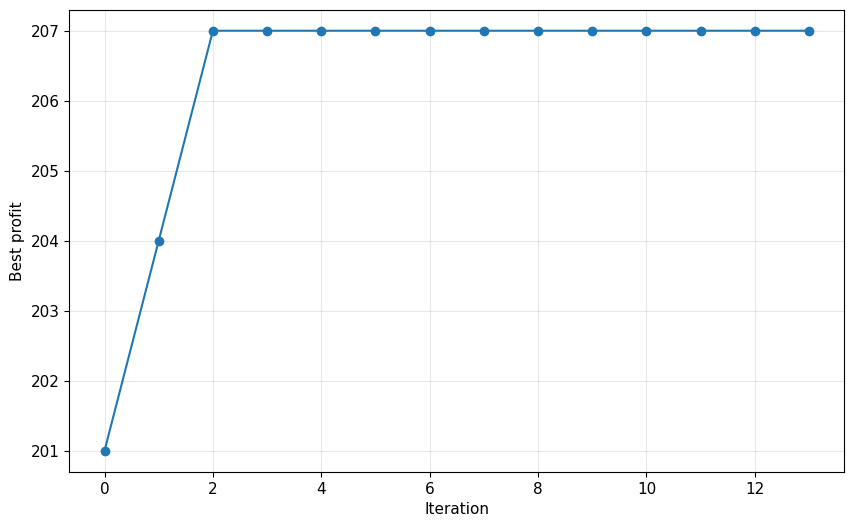

207
[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]
Best solution objective: 207, weight: 150, feasible: True


In [23]:
plt.figure()
plt.plot(results['history'], marker='o')
#plt.title('Best value per iteration')
plt.xlabel('Iteration')
plt.ylabel('Best profit')
plt.show()

print(results['best_value'])
print(results['best_solution'])

# compute the objective and weight of the best solution
best_obj = objective(problem, results['best_solution'])
best_wt = total_weight(problem, results['best_solution'])
print(f'Best solution objective: {best_obj}, weight: {best_wt}, feasible: {is_feasible(problem, results["best_solution"])}')
